## 1. Libraries 📖

In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

from sklearn import metrics

import matplotlib.pyplot as plt

np.random.seed(1234)

## 2. Metrics 📏

In [2]:
def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square, '\n')
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square

## 3. Load data 📊

In [3]:
df_train = pd.read_csv("../../data/train/solubility/solub_maccs_train.csv")
df_test = pd.read_csv("../../data/train/solubility/solub_maccs_test.csv")
df_valid = pd.read_csv("../../data/train/solubility/solub_maccs_valid.csv")

df_train_all = pd.concat([df_train, df_valid])

In [4]:
X_train_all = df_train_all.loc[:, df_train_all.columns != 'solubility']
y_train_all = df_train_all['solubility']

X_train = df_train_all.loc[:, df_train_all.columns != 'solubility']
y_train = df_train_all['solubility']

X_test = df_test.loc[:, df_test.columns != 'solubility']
y_test = df_test['solubility']

X_valid = df_valid.loc[:, df_valid.columns != 'solubility']
y_valid = df_valid['solubility']

In [5]:
X_train.shape

(1410, 166)

In [6]:
X_test.shape

(353, 166)

In [7]:
X_valid.shape

(176, 166)

# 4. Model ⚙️

![FCNN](images/fcnn.png)

In [8]:
class FCNN(nn.Module):
    def __init__(self):
        super(FCNN, self).__init__()
        self.linear1 = nn.Linear(166, 300)
        self.linear2 = nn.Linear(300, 500)
        self.linear3 = nn.Linear(500, 600)
        self.linear4 = nn.Linear(600, 400)
        self.linear5 = nn.Linear(400, 50)
        self.linear6 = nn.Linear(50, 1)
        self.dropout = torch.nn.Dropout(0.5)
        self.batch = torch.nn.BatchNorm1d(500)
        self.batch2 = torch.nn.BatchNorm1d(600)
        
    def forward(self, x):
        y_pred = F.relu(self.linear1(x))
        y_pred = self.dropout(y_pred)
        y_pred = F.relu(self.batch(self.linear2(y_pred)))
        y_pred = self.dropout(y_pred)
        y_pred = F.relu(self.batch2(self.linear3(y_pred)))
        y_pred = self.dropout(y_pred)
        y_pred = F.relu(self.linear4(y_pred))
        y_pred = F.relu(self.linear5(y_pred))
        y_pred = self.dropout(y_pred)
        y_pred = self.linear6(y_pred)
        return y_pred

## 4.1. Grid search 🔎

In [9]:
lrs = [0.001, 0.005, 0.01, 0.05]
batch_sizes = [32, 64, 128, 256]

In [10]:
best_value = 1
best_params = {'lr': None, 'batch_size': None, 'epoch': None, 'train_loss': None, 'test_loss': None,'train_acc': None,'test_acc': None}
train_losses_all = []
test_losses_all = []
train_accs_all = []
test_accs_all = []

for lr in lrs:
    for batch_size in batch_sizes:
        
        model = FCNN()
        model.cuda()
        
        train_dataset = TensorDataset(torch.FloatTensor(X_train.values), torch.FloatTensor(y_train.values.reshape(-1, 1)))
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

        valid_dataset = TensorDataset(torch.FloatTensor(X_valid.values), torch.FloatTensor(y_valid.values.reshape(-1, 1)))
        valid_loader = DataLoader(valid_dataset, batch_size=176, shuffle=False)

        epochs = 300
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr)

        train_losses = []
        test_losses = []
        train_accs = []
        test_accs = []
        
        print('Model: lr {}, batch_size {}'.format(lr, batch_size))

        for epoch in range(1, epochs + 1):

            print('################## EPOCH {} ##################'.format(epoch))

            model.train()
            train_correct = 0
            train_loss = 0


            for batch_idx, (data, target) in enumerate(train_loader):
                data, target = data.cuda(), target.cuda()
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                train_correct += metrics.r2_score(target.cpu().detach().numpy(), output.cpu().detach().numpy())

            train_loss /= len(train_loader)
            train_losses.append(train_loss)
            train_acc = train_correct/len(train_loader)
            train_accs.append(train_acc)
            print('Train Avg. loss: {}, Accuracy: {}'.format(train_loss, train_acc))

            model.eval()

            test_loss = 0
            test_correct = 0

            with torch.no_grad():
                for data, target in valid_loader:
                    data, target = data.cuda(), target.cuda()
                    output = model(data)
                    test_loss += criterion(output, target).item()
                    test_correct += metrics.r2_score(target.cpu().detach().numpy(), output.cpu().detach().numpy())

            test_loss /= len(valid_loader)
            test_losses.append(test_loss)
            test_acc =test_correct/len(valid_loader)
            test_accs.append(test_acc)

            if test_loss<best_value:
                best_value = test_loss
                best_params['lr'] = lr
                best_params['batch_size'] = batch_size
                best_params['epoch'] = epoch
                best_params['train_loss'] = train_loss
                best_params['test_loss'] = test_loss
                best_params['train_acc'] = train_acc
                best_params['test_acc'] = test_acc 
            print('Test Avg. loss: {}, Accuracy: {}'.format(test_loss, test_acc))

        train_losses_all.append(train_losses)
        test_losses_all.append(test_losses)
        train_accs_all.append(train_accs)
        test_accs_all.append(test_accs)

print(best_params)

Model: lr 0.001, batch_size 32
################## EPOCH 1 ##################
Train Avg. loss: 3.675401955180698, Accuracy: -3.172780706324485
Test Avg. loss: 6.362081527709961, Accuracy: -6.882208663816063
################## EPOCH 2 ##################
Train Avg. loss: 2.1154289735688105, Accuracy: -1.385301664122013
Test Avg. loss: 2.99712872505188, Accuracy: -2.713249070637207
################## EPOCH 3 ##################
Train Avg. loss: 2.03500994708803, Accuracy: -1.28703153501921
Test Avg. loss: 2.3183605670928955, Accuracy: -1.872299426855374
################## EPOCH 4 ##################
Train Avg. loss: 2.08038686381446, Accuracy: -1.3546037952283356
Test Avg. loss: 2.5463054180145264, Accuracy: -2.154708204023094
################## EPOCH 5 ##################
Train Avg. loss: 1.9798206326034333, Accuracy: -1.252643011712162
Test Avg. loss: 1.824676513671875, Accuracy: -1.2606565993422088
################## EPOCH 6 ##################
Train Avg. loss: 1.948243228594462, Accuracy: 

Train Avg. loss: 1.304305092493693, Accuracy: -0.484304699413778
Test Avg. loss: 0.6945040822029114, Accuracy: 0.13955424928873938
################## EPOCH 48 ##################
Train Avg. loss: 1.2502382539212704, Accuracy: -0.4074541966811002
Test Avg. loss: 0.7094441056251526, Accuracy: 0.1210444268523242
################## EPOCH 49 ##################
Train Avg. loss: 1.347524967458513, Accuracy: -0.5210112034777938
Test Avg. loss: 0.6556127667427063, Accuracy: 0.1877380029648622
################## EPOCH 50 ##################
Train Avg. loss: 1.319314139419132, Accuracy: -0.4915393038215988
Test Avg. loss: 0.6898158192634583, Accuracy: 0.14536269307133576
################## EPOCH 51 ##################
Train Avg. loss: 1.246101521121131, Accuracy: -0.4233382515746189
Test Avg. loss: 0.6906255483627319, Accuracy: 0.14435937346168026
################## EPOCH 52 ##################
Train Avg. loss: 1.275193410449558, Accuracy: -0.4334188606986171
Test Avg. loss: 0.6908013224601746, Accur

Train Avg. loss: 0.9473501632610957, Accuracy: -0.05993148695587658
Test Avg. loss: 0.4666516184806824, Accuracy: 0.4218486877907287
################## EPOCH 94 ##################
Train Avg. loss: 0.8939197659492493, Accuracy: -0.01153541719276996
Test Avg. loss: 0.4659965932369232, Accuracy: 0.4226602804552567
################## EPOCH 95 ##################
Train Avg. loss: 0.8595376438564725, Accuracy: 0.013154551693899539
Test Avg. loss: 0.4394533038139343, Accuracy: 0.4555456550807706
################## EPOCH 96 ##################
Train Avg. loss: 0.9088368084695604, Accuracy: -0.03402464402364008
Test Avg. loss: 0.48605066537857056, Accuracy: 0.3978145177146163
################## EPOCH 97 ##################
Train Avg. loss: 0.932714178495937, Accuracy: -0.05320999047370208
Test Avg. loss: 0.4564584493637085, Accuracy: 0.43447738606391173
################## EPOCH 98 ##################
Train Avg. loss: 0.8943606615066528, Accuracy: -0.005216671320153184
Test Avg. loss: 0.473559379577

Train Avg. loss: 0.6256882727146149, Accuracy: 0.29391540969259156
Test Avg. loss: 0.34205302596092224, Accuracy: 0.5762183453498699
################## EPOCH 141 ##################
Train Avg. loss: 0.6347535192966461, Accuracy: 0.28665832400898217
Test Avg. loss: 0.3596465587615967, Accuracy: 0.5544211041264523
################## EPOCH 142 ##################
Train Avg. loss: 0.5986492501364814, Accuracy: 0.3127401644879033
Test Avg. loss: 0.31477949023246765, Accuracy: 0.6100084787137259
################## EPOCH 143 ##################
Train Avg. loss: 0.5827624513043298, Accuracy: 0.34609668075969097
Test Avg. loss: 0.33047816157341003, Accuracy: 0.5905588676079169
################## EPOCH 144 ##################
Train Avg. loss: 0.6854989422692193, Accuracy: 0.2304486833047716
Test Avg. loss: 0.36829909682273865, Accuracy: 0.543701131161147
################## EPOCH 145 ##################
Train Avg. loss: 0.7134823580582936, Accuracy: 0.20374619642783687
Test Avg. loss: 0.38551643490791

Train Avg. loss: 0.4638245532082187, Accuracy: 0.470887044531355
Test Avg. loss: 0.23894155025482178, Accuracy: 0.7039668082473655
################## EPOCH 187 ##################
Train Avg. loss: 0.472407839116123, Accuracy: 0.46788995699978086
Test Avg. loss: 0.2447677105665207, Accuracy: 0.6967485493181782
################## EPOCH 188 ##################
Train Avg. loss: 0.46872467862235173, Accuracy: 0.466318781981123
Test Avg. loss: 0.24717235565185547, Accuracy: 0.6937693767494981
################## EPOCH 189 ##################
Train Avg. loss: 0.48297256280978523, Accuracy: 0.45786658165182625
Test Avg. loss: 0.2648669183254242, Accuracy: 0.6718469670404763
################## EPOCH 190 ##################
Train Avg. loss: 0.45520677036709256, Accuracy: 0.47972053175323087
Test Avg. loss: 0.2524239122867584, Accuracy: 0.6872630382277192
################## EPOCH 191 ##################
Train Avg. loss: 0.48527976075808205, Accuracy: 0.45819727126413223
Test Avg. loss: 0.26356688141822

Train Avg. loss: 0.39273831579420304, Accuracy: 0.5512077423447443
Test Avg. loss: 0.23862247169017792, Accuracy: 0.7043621208870052
################## EPOCH 233 ##################
Train Avg. loss: 0.38126233220100403, Accuracy: 0.569508313641889
Test Avg. loss: 0.21509745717048645, Accuracy: 0.7335081109620925
################## EPOCH 234 ##################
Train Avg. loss: 0.4690363731649187, Accuracy: 0.4877416919537973
Test Avg. loss: 0.2319144606590271, Accuracy: 0.7126729372786885
################## EPOCH 235 ##################
Train Avg. loss: 0.4431787093480428, Accuracy: 0.5043818790936053
Test Avg. loss: 0.24789054691791534, Accuracy: 0.6928795873215083
################## EPOCH 236 ##################
Train Avg. loss: 0.38809571398629084, Accuracy: 0.566804745150194
Test Avg. loss: 0.21289551258087158, Accuracy: 0.7362361599315238
################## EPOCH 237 ##################
Train Avg. loss: 0.3648745056655672, Accuracy: 0.5790437373984687
Test Avg. loss: 0.2191505879163742

Train Avg. loss: 0.29305471444709436, Accuracy: 0.6673055544894242
Test Avg. loss: 0.18367256224155426, Accuracy: 0.7724415474086708
################## EPOCH 279 ##################
Train Avg. loss: 0.31773377938403025, Accuracy: 0.6385812600317624
Test Avg. loss: 0.19708864390850067, Accuracy: 0.7558198902362737
################## EPOCH 280 ##################
Train Avg. loss: 0.2946041476395395, Accuracy: 0.6639205543890199
Test Avg. loss: 0.1871902495622635, Accuracy: 0.768083348800059
################## EPOCH 281 ##################
Train Avg. loss: 0.3204429739051395, Accuracy: 0.6379397685874436
Test Avg. loss: 0.18178106844425201, Accuracy: 0.7747849633600552
################## EPOCH 282 ##################
Train Avg. loss: 0.3170725683371226, Accuracy: 0.6363669268329347
Test Avg. loss: 0.19624365866184235, Accuracy: 0.7568667486307821
################## EPOCH 283 ##################
Train Avg. loss: 0.3112808283832338, Accuracy: 0.645977788753373
Test Avg. loss: 0.16961579024791718

Train Avg. loss: 1.8681648503179136, Accuracy: -1.0648419316781685
Test Avg. loss: 0.9668328166007996, Accuracy: -0.1978435015267277
################## EPOCH 25 ##################
Train Avg. loss: 1.6798306548077127, Accuracy: -0.8584312328928527
Test Avg. loss: 0.8336062431335449, Accuracy: -0.03278441528139231
################## EPOCH 26 ##################
Train Avg. loss: 1.9491210813107698, Accuracy: -1.101277159510404
Test Avg. loss: 1.307355284690857, Accuracy: -0.619728975210841
################## EPOCH 27 ##################
Train Avg. loss: 2.151489063449528, Accuracy: -1.3629368908073487
Test Avg. loss: 1.0944387912750244, Accuracy: -0.35593924005768485
################## EPOCH 28 ##################
Train Avg. loss: 1.927289219006248, Accuracy: -1.0910672889216144
Test Avg. loss: 0.9859962463378906, Accuracy: -0.2215859611523472
################## EPOCH 29 ##################
Train Avg. loss: 1.8059870885766072, Accuracy: -0.9841857020825959
Test Avg. loss: 0.7659295201301575, 

Train Avg. loss: 1.4719350415727366, Accuracy: -0.5943362399109586
Test Avg. loss: 0.7235286831855774, Accuracy: 0.10359453251544959
################## EPOCH 72 ##################
Train Avg. loss: 1.7425342124441396, Accuracy: -0.8617482930429781
Test Avg. loss: 0.8002722859382629, Accuracy: 0.008514155528875245
################## EPOCH 73 ##################
Train Avg. loss: 1.4561992676361748, Accuracy: -0.5961817682873073
Test Avg. loss: 0.7656766176223755, Accuracy: 0.05137600723366609
################## EPOCH 74 ##################
Train Avg. loss: 1.34585186968679, Accuracy: -0.4959421348030862
Test Avg. loss: 0.7022556662559509, Accuracy: 0.12995050237776107
################## EPOCH 75 ##################
Train Avg. loss: 1.316341045110122, Accuracy: -0.44682298475060617
Test Avg. loss: 0.7176986932754517, Accuracy: 0.110817560108603
################## EPOCH 76 ##################
Train Avg. loss: 1.61956438810929, Accuracy: -0.7322025800061421
Test Avg. loss: 0.7564952373504639, Ac

Train Avg. loss: 1.1171203488888948, Accuracy: -0.21620041728846343
Test Avg. loss: 0.5730223655700684, Accuracy: 0.29006220651487913
################## EPOCH 118 ##################
Train Avg. loss: 0.989206577124803, Accuracy: -0.10680585550324452
Test Avg. loss: 0.4482097625732422, Accuracy: 0.4446969732740941
################## EPOCH 119 ##################
Train Avg. loss: 0.9878944573195084, Accuracy: -0.08601260329499019
Test Avg. loss: 0.5004473328590393, Accuracy: 0.37997797320053583
################## EPOCH 120 ##################
Train Avg. loss: 1.1893283932105354, Accuracy: -0.2868591138069058
Test Avg. loss: 0.4488380253314972, Accuracy: 0.4439186059622132
################## EPOCH 121 ##################
Train Avg. loss: 1.1020132380983103, Accuracy: -0.2140584241589739
Test Avg. loss: 0.4934973418712616, Accuracy: 0.3885885703344838
################## EPOCH 122 ##################
Train Avg. loss: 1.1857415385868237, Accuracy: -0.29200133634768854
Test Avg. loss: 0.4814292788

Train Avg. loss: 0.9111389284548552, Accuracy: 0.005878019014219481
Test Avg. loss: 0.40016573667526245, Accuracy: 0.504220427454498
################## EPOCH 164 ##################
Train Avg. loss: 0.8603532599366229, Accuracy: 0.05688688614632197
Test Avg. loss: 0.42618098855018616, Accuracy: 0.47198922757738637
################## EPOCH 165 ##################
Train Avg. loss: 1.0342206073843914, Accuracy: -0.1252032836780403
Test Avg. loss: 0.4495879113674164, Accuracy: 0.44298951061395053
################## EPOCH 166 ##################
Train Avg. loss: 0.8935663622358571, Accuracy: 0.016860839545024594
Test Avg. loss: 0.44697338342666626, Accuracy: 0.4462288178460593
################## EPOCH 167 ##################
Train Avg. loss: 0.9614356704380201, Accuracy: -0.039757965872789736
Test Avg. loss: 0.4220598638057709, Accuracy: 0.4770950230295987
################## EPOCH 168 ##################
Train Avg. loss: 0.9152333736419678, Accuracy: 0.00793715936904501
Test Avg. loss: 0.5302604

Train Avg. loss: 0.810759961605072, Accuracy: 0.1334721600042821
Test Avg. loss: 0.3602274954319, Accuracy: 0.553701392171023
################## EPOCH 210 ##################
Train Avg. loss: 0.6394935183874939, Accuracy: 0.28406800156869616
Test Avg. loss: 0.3640825152397156, Accuracy: 0.5489252453674194
################## EPOCH 211 ##################
Train Avg. loss: 0.7012894814429076, Accuracy: 0.23953380092565416
Test Avg. loss: 0.3645714223384857, Accuracy: 0.5483195190196404
################## EPOCH 212 ##################
Train Avg. loss: 0.6460739127967668, Accuracy: 0.28268813823241856
Test Avg. loss: 0.37144315242767334, Accuracy: 0.5398058293886832
################## EPOCH 213 ##################
Train Avg. loss: 0.5955472990222599, Accuracy: 0.34270427177484575
Test Avg. loss: 0.3840004801750183, Accuracy: 0.5242481362035893
################## EPOCH 214 ##################
Train Avg. loss: 0.6916887967482858, Accuracy: 0.24815961789692448
Test Avg. loss: 0.3330329358577728, Ac

Train Avg. loss: 0.6566669850245767, Accuracy: 0.27316525948350623
Test Avg. loss: 0.3249298632144928, Accuracy: 0.5974328010479928
################## EPOCH 256 ##################
Train Avg. loss: 0.6668575807757999, Accuracy: 0.2728343313285466
Test Avg. loss: 0.35140037536621094, Accuracy: 0.5646375657649886
################## EPOCH 257 ##################
Train Avg. loss: 0.5672611166601595, Accuracy: 0.3693475293299918
Test Avg. loss: 0.29086893796920776, Accuracy: 0.6396320883784088
################## EPOCH 258 ##################
Train Avg. loss: 0.5822302750919176, Accuracy: 0.3663633521325723
Test Avg. loss: 0.3010157644748688, Accuracy: 0.6270608313886703
################## EPOCH 259 ##################
Train Avg. loss: 0.5447265181852423, Accuracy: 0.3992349197378005
Test Avg. loss: 0.358266681432724, Accuracy: 0.5561307077149035
################## EPOCH 260 ##################
Train Avg. loss: 0.5493804916091587, Accuracy: 0.3918285426391158
Test Avg. loss: 0.37009578943252563, 

Train Avg. loss: 8.059442222118378, Accuracy: -7.482440282520272
Test Avg. loss: 10.81761646270752, Accuracy: -12.402331087024388
################## EPOCH 2 ##################
Train Avg. loss: 2.635664999485016, Accuracy: -1.7895730555177167
Test Avg. loss: 8.299365043640137, Accuracy: -9.282378717002693
################## EPOCH 3 ##################
Train Avg. loss: 2.272246460119883, Accuracy: -1.4277350736109609
Test Avg. loss: 6.117025375366211, Accuracy: -6.578600556906836
################## EPOCH 4 ##################
Train Avg. loss: 2.7807575464248657, Accuracy: -1.8727577822839157
Test Avg. loss: 5.166236400604248, Accuracy: -5.400634276964829
################## EPOCH 5 ##################
Train Avg. loss: 2.339502821365992, Accuracy: -1.4802593856397055
Test Avg. loss: 2.9210102558135986, Accuracy: -2.6189432907797907
################## EPOCH 6 ##################
Train Avg. loss: 1.9849675448300939, Accuracy: -1.1464113594210026
Test Avg. loss: 3.371471881866455, Accuracy: -3.17

Train Avg. loss: 2.213023473819097, Accuracy: -1.2871048166436345
Test Avg. loss: 0.7495093941688538, Accuracy: 0.07140609789391117
################## EPOCH 48 ##################
Train Avg. loss: 1.9422398408253987, Accuracy: -1.0700114467074755
Test Avg. loss: 0.766998827457428, Accuracy: 0.04973781436629654
################## EPOCH 49 ##################
Train Avg. loss: 1.830101082722346, Accuracy: -0.9636544575369084
Test Avg. loss: 0.7411227226257324, Accuracy: 0.0817967257724751
################## EPOCH 50 ##################
Train Avg. loss: 1.7599530617396038, Accuracy: -0.8946118789940328
Test Avg. loss: 0.7839815020561218, Accuracy: 0.028697403491020346
################## EPOCH 51 ##################
Train Avg. loss: 1.774565577507019, Accuracy: -0.9006981563563646
Test Avg. loss: 0.7559459209442139, Accuracy: 0.0634317550385547
################## EPOCH 52 ##################
Train Avg. loss: 2.2691581646601358, Accuracy: -1.351961696468192
Test Avg. loss: 0.7137197256088257, Acc

Train Avg. loss: 1.7868483364582062, Accuracy: -0.8673345967138809
Test Avg. loss: 1.0619878768920898, Accuracy: -0.3157344810257683
################## EPOCH 96 ##################
Train Avg. loss: 1.6159661412239075, Accuracy: -0.7106864513214588
Test Avg. loss: 0.6354001760482788, Accuracy: 0.21278011531776286
################## EPOCH 97 ##################
Train Avg. loss: 1.5162074168523152, Accuracy: -0.613061721572608
Test Avg. loss: 0.7972819209098816, Accuracy: 0.012219074236412109
################## EPOCH 98 ##################
Train Avg. loss: 1.4336933344602585, Accuracy: -0.5521646256473062
Test Avg. loss: 1.0146629810333252, Accuracy: -0.25710217722431516
################## EPOCH 99 ##################
Train Avg. loss: 1.8451928993066151, Accuracy: -0.9368850956296537
Test Avg. loss: 0.5749480128288269, Accuracy: 0.2876764058841661
################## EPOCH 100 ##################
Train Avg. loss: 1.7647082110246022, Accuracy: -0.8203389673600426
Test Avg. loss: 0.95235586166381

Train Avg. loss: 1.2623279392719269, Accuracy: -0.34297136734996475
Test Avg. loss: 0.9840846061706543, Accuracy: -0.2192173441621046
################## EPOCH 144 ##################
Train Avg. loss: 1.4892200926939647, Accuracy: -0.54842447860087
Test Avg. loss: 0.5304573178291321, Accuracy: 0.342797557764417
################## EPOCH 145 ##################
Train Avg. loss: 1.4049399743477504, Accuracy: -0.5100743293364864
Test Avg. loss: 0.7236413955688477, Accuracy: 0.10345486619411182
################## EPOCH 146 ##################
Train Avg. loss: 1.2579266528288524, Accuracy: -0.33710812667269313
Test Avg. loss: 0.5497470498085022, Accuracy: 0.3188988043094151
################## EPOCH 147 ##################
Train Avg. loss: 1.5183464288711548, Accuracy: -0.5982992624741132
Test Avg. loss: 0.7876982688903809, Accuracy: 0.02409257168572765
################## EPOCH 148 ##################
Train Avg. loss: 1.194604054093361, Accuracy: -0.2916260389411756
Test Avg. loss: 1.07235646247863

Train Avg. loss: 1.1040588021278381, Accuracy: -0.1827176133068863
Test Avg. loss: 0.6700142025947571, Accuracy: 0.1698954901898866
################## EPOCH 192 ##################
Train Avg. loss: 1.091600311299165, Accuracy: -0.17206295638808966
Test Avg. loss: 0.5662358999252319, Accuracy: 0.2984701344353723
################## EPOCH 193 ##################
Train Avg. loss: 1.2230439732472103, Accuracy: -0.272610910472108
Test Avg. loss: 1.0391007661819458, Accuracy: -0.2873789382256151
################## EPOCH 194 ##################
Train Avg. loss: 1.086999515692393, Accuracy: -0.15816569150109763
Test Avg. loss: 0.9250973463058472, Accuracy: -0.14613599425932722
################## EPOCH 195 ##################
Train Avg. loss: 1.0434678097565968, Accuracy: -0.11590175787472819
Test Avg. loss: 0.8907207250595093, Accuracy: -0.10354556667678527
################## EPOCH 196 ##################
Train Avg. loss: 1.2193746715784073, Accuracy: -0.2703472001050713
Test Avg. loss: 0.5550997853

Train Avg. loss: 1.0992591281731923, Accuracy: -0.1635136123301873
Test Avg. loss: 0.5710887908935547, Accuracy: 0.29245775159880594
################## EPOCH 240 ##################
Train Avg. loss: 0.9884997059901556, Accuracy: -0.045122247617829125
Test Avg. loss: 0.5159134268760681, Accuracy: 0.36081651930892544
################## EPOCH 241 ##################
Train Avg. loss: 1.037015696366628, Accuracy: -0.10369715916104481
Test Avg. loss: 0.5717129707336426, Accuracy: 0.2916844634768271
################## EPOCH 242 ##################
Train Avg. loss: 0.9361547927061716, Accuracy: -0.004238996579854233
Test Avg. loss: 0.6431365609169006, Accuracy: 0.20319524486687812
################## EPOCH 243 ##################
Train Avg. loss: 1.0361632059017818, Accuracy: -0.09169149481078316
Test Avg. loss: 0.5483681559562683, Accuracy: 0.32060717954015006
################## EPOCH 244 ##################
Train Avg. loss: 0.9328670352697372, Accuracy: -0.010791152935073739
Test Avg. loss: 0.6230

Train Avg. loss: 0.8559866547584534, Accuracy: 0.08244894985911046
Test Avg. loss: 0.44753003120422363, Accuracy: 0.44553914872375155
################## EPOCH 288 ##################
Train Avg. loss: 0.8584802001714706, Accuracy: 0.08940208859274208
Test Avg. loss: 0.5072972774505615, Accuracy: 0.37149138952933314
################## EPOCH 289 ##################
Train Avg. loss: 0.8421787371238073, Accuracy: 0.10469712685317441
Test Avg. loss: 0.5689805746078491, Accuracy: 0.2950697151103703
################## EPOCH 290 ##################
Train Avg. loss: 0.7749371317525705, Accuracy: 0.16288652137982082
Test Avg. loss: 0.5616957545280457, Accuracy: 0.30409514641997404
################## EPOCH 291 ##################
Train Avg. loss: 0.746860126654307, Accuracy: 0.19904449951427314
Test Avg. loss: 0.46891093254089355, Accuracy: 0.4190495913025122
################## EPOCH 292 ##################
Train Avg. loss: 0.7717953970034918, Accuracy: 0.16727073052679842
Test Avg. loss: 0.46871906518

Train Avg. loss: 1.6807887355486553, Accuracy: -0.8230201955409383
Test Avg. loss: 2.931156635284424, Accuracy: -2.6315139083543504
################## EPOCH 35 ##################
Train Avg. loss: 1.6570639212926228, Accuracy: -0.8118432708841251
Test Avg. loss: 2.7460834980010986, Accuracy: -2.402220313303842
################## EPOCH 36 ##################
Train Avg. loss: 1.681943674882253, Accuracy: -0.8283133285854459
Test Avg. loss: 2.4462015628814697, Accuracy: -2.030686001519481
################## EPOCH 37 ##################
Train Avg. loss: 1.6621461113293965, Accuracy: -0.7994007993807185
Test Avg. loss: 2.9617831707000732, Accuracy: -2.6694586019412805
################## EPOCH 38 ##################
Train Avg. loss: 1.6237024068832397, Accuracy: -0.780611626549307
Test Avg. loss: 3.1127021312713623, Accuracy: -2.8564376418739297
################## EPOCH 39 ##################
Train Avg. loss: 1.665386974811554, Accuracy: -0.8084007015667017
Test Avg. loss: 3.328010082244873, Accu

Train Avg. loss: 1.4503633975982666, Accuracy: -0.5756299498073237
Test Avg. loss: 2.6720099449157715, Accuracy: -2.3104481746369756
################## EPOCH 83 ##################
Train Avg. loss: 1.4914633830388386, Accuracy: -0.6260074130827555
Test Avg. loss: 2.4742679595947266, Accuracy: -2.065458891601853
################## EPOCH 84 ##################
Train Avg. loss: 1.4696214199066162, Accuracy: -0.6009797837374483
Test Avg. loss: 2.4721100330352783, Accuracy: -2.0627851447107006
################## EPOCH 85 ##################
Train Avg. loss: 1.4302676320075989, Accuracy: -0.5571081713212487
Test Avg. loss: 2.254854917526245, Accuracy: -1.7936200375789157
################## EPOCH 86 ##################
Train Avg. loss: 1.3049167195955913, Accuracy: -0.41577149515981376
Test Avg. loss: 2.129812240600586, Accuracy: -1.6387001036753532
################## EPOCH 87 ##################
Train Avg. loss: 1.4549416502316792, Accuracy: -0.5854360698006015
Test Avg. loss: 2.265106439590454, 

Train Avg. loss: 1.3773802320162456, Accuracy: -0.49932809913460313
Test Avg. loss: 1.2630457878112793, Accuracy: -0.5648324663835138
################## EPOCH 133 ##################
Train Avg. loss: 1.3647718230883281, Accuracy: -0.4770015075508291
Test Avg. loss: 1.3874579668045044, Accuracy: -0.7189710646300249
################## EPOCH 134 ##################
Train Avg. loss: 1.3487273454666138, Accuracy: -0.4725279922720243
Test Avg. loss: 1.9200949668884277, Accuracy: -1.3788740014739416
################## EPOCH 135 ##################
Train Avg. loss: 1.2316463490327199, Accuracy: -0.3330264207534563
Test Avg. loss: 1.4380420446395874, Accuracy: -0.7816414950616446
################## EPOCH 136 ##################
Train Avg. loss: 1.3628862698872883, Accuracy: -0.4856790346282959
Test Avg. loss: 1.7638918161392212, Accuracy: -1.1853481689881669
################## EPOCH 137 ##################
Train Avg. loss: 1.2541486620903015, Accuracy: -0.3646373144709973
Test Avg. loss: 1.487425565

Train Avg. loss: 1.1571660339832306, Accuracy: -0.2526034774338826
Test Avg. loss: 1.3097689151763916, Accuracy: -0.6227192378711826
################## EPOCH 181 ##################
Train Avg. loss: 1.1745103001594543, Accuracy: -0.26671917750098556
Test Avg. loss: 1.482640266418457, Accuracy: -0.8368956976975481
################## EPOCH 182 ##################
Train Avg. loss: 1.1969959735870361, Accuracy: -0.29997268038495356
Test Avg. loss: 1.1666929721832275, Accuracy: -0.44545744607217896
################## EPOCH 183 ##################
Train Avg. loss: 1.0742579797903697, Accuracy: -0.16675071292845658
Test Avg. loss: 1.4166141748428345, Accuracy: -0.7550936842917755
################## EPOCH 184 ##################
Train Avg. loss: 1.1115805904070537, Accuracy: -0.20821542635149182
Test Avg. loss: 1.3080815076828003, Accuracy: -0.6206288027119318
################## EPOCH 185 ##################
Train Avg. loss: 1.0893955727418263, Accuracy: -0.18309031494898406
Test Avg. loss: 1.33062

Train Avg. loss: 0.9852811396121979, Accuracy: -0.06815949328087856
Test Avg. loss: 1.1605024337768555, Accuracy: -0.43778786365976274
################## EPOCH 230 ##################
Train Avg. loss: 1.0795615116755168, Accuracy: -0.17936433531120236
Test Avg. loss: 1.057816743850708, Accuracy: -0.3105667838637507
################## EPOCH 231 ##################
Train Avg. loss: 0.9501248399416605, Accuracy: -0.02779995643959458
Test Avg. loss: 1.424559473991394, Accuracy: -0.7649374133442792
################## EPOCH 232 ##################
Train Avg. loss: 0.971840629975001, Accuracy: -0.05140764580212722
Test Avg. loss: 1.0760219097137451, Accuracy: -0.3331218771882709
################## EPOCH 233 ##################
Train Avg. loss: 1.032155990600586, Accuracy: -0.12096333907298666
Test Avg. loss: 0.9933149218559265, Accuracy: -0.23065328722158496
################## EPOCH 234 ##################
Train Avg. loss: 1.0850549340248108, Accuracy: -0.1853292428953741
Test Avg. loss: 1.4853560

Train Avg. loss: 1.0127218266328175, Accuracy: -0.10301463527097106
Test Avg. loss: 0.8464010953903198, Accuracy: -0.04863640185161855
################## EPOCH 276 ##################
Train Avg. loss: 0.9153022964795431, Accuracy: 0.00836117240224954
Test Avg. loss: 0.93092280626297, Accuracy: -0.15335347363899055
################## EPOCH 277 ##################
Train Avg. loss: 0.8821301162242889, Accuracy: 0.04079862765751335
Test Avg. loss: 0.8925362825393677, Accuracy: -0.10579494367048858
################## EPOCH 278 ##################
Train Avg. loss: 0.8874085148175558, Accuracy: 0.03066862776178138
Test Avg. loss: 0.8261088132858276, Accuracy: -0.023495512096007864
################## EPOCH 279 ##################
Train Avg. loss: 0.8802012503147125, Accuracy: 0.04360813152708256
Test Avg. loss: 0.9597667455673218, Accuracy: -0.18908914177499891
################## EPOCH 280 ##################
Train Avg. loss: 0.8872577250003815, Accuracy: 0.03233874470587611
Test Avg. loss: 0.96710

Train Avg. loss: 1.2797117604149713, Accuracy: -0.4417528978682525
Test Avg. loss: 0.7387946844100952, Accuracy: 0.08468089070010132
################## EPOCH 22 ##################
Train Avg. loss: 1.3658961640463936, Accuracy: -0.5446142762846402
Test Avg. loss: 0.7963366508483887, Accuracy: 0.01339022538082757
################## EPOCH 23 ##################
Train Avg. loss: 1.1634278217951457, Accuracy: -0.3122438649267418
Test Avg. loss: 0.7374057769775391, Accuracy: 0.08640172771999988
################## EPOCH 24 ##################
Train Avg. loss: 1.1406043701701694, Accuracy: -0.27681023296878954
Test Avg. loss: 0.7301158308982849, Accuracy: 0.09543346044064438
################## EPOCH 25 ##################
Train Avg. loss: 1.143072772026062, Accuracy: -0.2836511061973692
Test Avg. loss: 0.6975086331367493, Accuracy: 0.13583174729808556
################## EPOCH 26 ##################
Train Avg. loss: 1.0610228141148885, Accuracy: -0.17846331463957135
Test Avg. loss: 0.68042445182800

Train Avg. loss: 0.6779534896214803, Accuracy: 0.251029448708674
Test Avg. loss: 0.48649081587791443, Accuracy: 0.39726920062877513
################## EPOCH 68 ##################
Train Avg. loss: 0.6425210240814421, Accuracy: 0.28692422862044
Test Avg. loss: 0.5262643694877625, Accuracy: 0.34799228652694447
################## EPOCH 69 ##################
Train Avg. loss: 0.631011325120926, Accuracy: 0.3016166090924767
Test Avg. loss: 0.5194460153579712, Accuracy: 0.3564398871405541
################## EPOCH 70 ##################
Train Avg. loss: 0.6218023664421506, Accuracy: 0.30590356359582377
Test Avg. loss: 0.4869893789291382, Accuracy: 0.39665155193398216
################## EPOCH 71 ##################
Train Avg. loss: 0.6439054369926452, Accuracy: 0.2817770392360532
Test Avg. loss: 0.49496227502822876, Accuracy: 0.3867735991922895
################## EPOCH 72 ##################
Train Avg. loss: 0.6366723577181498, Accuracy: 0.2920688268161034
Test Avg. loss: 0.5002256631851196, Accura

Train Avg. loss: 0.6061623964044783, Accuracy: 0.3246105059891767
Test Avg. loss: 0.4084189832210541, Accuracy: 0.493995177062283
################## EPOCH 114 ##################
Train Avg. loss: 0.6988936550087399, Accuracy: 0.2197464185528506
Test Avg. loss: 0.6684945821762085, Accuracy: 0.17177827803914858
################## EPOCH 115 ##################
Train Avg. loss: 0.7317029741075304, Accuracy: 0.18661466712358912
Test Avg. loss: 0.6426755785942078, Accuracy: 0.20376633678237233
################## EPOCH 116 ##################
Train Avg. loss: 0.6886788911289639, Accuracy: 0.2345496443296814
Test Avg. loss: 0.5602012872695923, Accuracy: 0.30594664264026816
################## EPOCH 117 ##################
Train Avg. loss: 0.6828097018930647, Accuracy: 0.25049462942655837
Test Avg. loss: 0.5512334704399109, Accuracy: 0.31705720330493237
################## EPOCH 118 ##################
Train Avg. loss: 0.6856330547067854, Accuracy: 0.24416026666118615
Test Avg. loss: 0.580550551414489

Train Avg. loss: 0.5729851649867164, Accuracy: 0.355917264572518
Test Avg. loss: 0.4536193609237671, Accuracy: 0.4379948039481665
################## EPOCH 160 ##################
Train Avg. loss: 0.583815727631251, Accuracy: 0.3603237804460045
Test Avg. loss: 0.4322558343410492, Accuracy: 0.4644628531392583
################## EPOCH 161 ##################
Train Avg. loss: 0.5646133893065982, Accuracy: 0.3674224292465508
Test Avg. loss: 0.41761693358421326, Accuracy: 0.4825995019110635
################## EPOCH 162 ##################
Train Avg. loss: 0.5668762346108754, Accuracy: 0.3605324483818329
Test Avg. loss: 0.42165353894233704, Accuracy: 0.4775984290757712
################## EPOCH 163 ##################
Train Avg. loss: 0.5985201252831354, Accuracy: 0.33808676207826954
Test Avg. loss: 0.48024362325668335, Accuracy: 0.4050090768064277
################## EPOCH 164 ##################
Train Avg. loss: 0.5555812736352285, Accuracy: 0.3764879165296917
Test Avg. loss: 0.39078187942504883, 

Train Avg. loss: 0.5969343668884701, Accuracy: 0.33028863348774845
Test Avg. loss: 0.45507389307022095, Accuracy: 0.4361928177541504
################## EPOCH 206 ##################
Train Avg. loss: 0.5636146823565166, Accuracy: 0.3691235385079186
Test Avg. loss: 0.4107290208339691, Accuracy: 0.4911331352270074
################## EPOCH 207 ##################
Train Avg. loss: 0.5665688468350305, Accuracy: 0.364350500559504
Test Avg. loss: 0.4553006589412689, Accuracy: 0.435911838310046
################## EPOCH 208 ##################
Train Avg. loss: 0.5877161191569434, Accuracy: 0.3484607617567722
Test Avg. loss: 0.4384217858314514, Accuracy: 0.4568236722026482
################## EPOCH 209 ##################
Train Avg. loss: 0.5645847565597958, Accuracy: 0.3678339913505141
Test Avg. loss: 0.4066261053085327, Accuracy: 0.49621648713708466
################## EPOCH 210 ##################
Train Avg. loss: 0.5705535418457455, Accuracy: 0.3556290201241642
Test Avg. loss: 0.4229200780391693, Ac

Train Avg. loss: 0.5452921271324158, Accuracy: 0.3898153512172322
Test Avg. loss: 0.36928272247314453, Accuracy: 0.5424824139779384
################## EPOCH 252 ##################
Train Avg. loss: 0.5423485226101346, Accuracy: 0.3952358881524482
Test Avg. loss: 0.38848501443862915, Accuracy: 0.5186921016597511
################## EPOCH 253 ##################
Train Avg. loss: 0.47830628123548297, Accuracy: 0.4545865361168331
Test Avg. loss: 0.39117732644081116, Accuracy: 0.515356540337926
################## EPOCH 254 ##################
Train Avg. loss: 0.5139507578478919, Accuracy: 0.42281097901943887
Test Avg. loss: 0.39137792587280273, Accuracy: 0.5151079330203345
################## EPOCH 255 ##################
Train Avg. loss: 0.5182727734247844, Accuracy: 0.4212325598965678
Test Avg. loss: 0.3751831650733948, Accuracy: 0.5351722473948383
################## EPOCH 256 ##################
Train Avg. loss: 0.4835484302706189, Accuracy: 0.4522719978527723
Test Avg. loss: 0.3656963407993316

Train Avg. loss: 0.53340715236134, Accuracy: 0.3989616595583175
Test Avg. loss: 0.36470508575439453, Accuracy: 0.5481539222035232
################## EPOCH 298 ##################
Train Avg. loss: 0.4885174459881253, Accuracy: 0.4530483376913323
Test Avg. loss: 0.3107375204563141, Accuracy: 0.6150162117702311
################## EPOCH 299 ##################
Train Avg. loss: 0.4710284239302079, Accuracy: 0.46633834868422464
Test Avg. loss: 0.3507636487483978, Accuracy: 0.5654264212678513
################## EPOCH 300 ##################
Train Avg. loss: 0.47691133485900034, Accuracy: 0.46147381397593706
Test Avg. loss: 0.35226044058799744, Accuracy: 0.563572052482459
Model: lr 0.005, batch_size 64
################## EPOCH 1 ##################
Train Avg. loss: 5.698980010074118, Accuracy: -5.124561639392753
Test Avg. loss: 13.84595775604248, Accuracy: -16.154249222935476
################## EPOCH 2 ##################
Train Avg. loss: 3.4504782894383306, Accuracy: -2.797937470095672
Test Avg. l

Train Avg. loss: 1.2359139193659243, Accuracy: -0.3589293669285988
Test Avg. loss: 0.7497144341468811, Accuracy: 0.07115207126857337
################## EPOCH 45 ##################
Train Avg. loss: 1.2427275854608286, Accuracy: -0.3599632125395517
Test Avg. loss: 0.7390123009681702, Accuracy: 0.08441137320026337
################## EPOCH 46 ##################
Train Avg. loss: 1.2152132314184438, Accuracy: -0.3182726255282649
Test Avg. loss: 0.7667593955993652, Accuracy: 0.050034543623215244
################## EPOCH 47 ##################
Train Avg. loss: 1.1874502093895623, Accuracy: -0.2956632297460966
Test Avg. loss: 0.7644605040550232, Accuracy: 0.05288268550268593
################## EPOCH 48 ##################
Train Avg. loss: 1.2322701889535654, Accuracy: -0.3520228264509687
Test Avg. loss: 0.6999692320823669, Accuracy: 0.13278328242280224
################## EPOCH 49 ##################
Train Avg. loss: 1.1693282075550244, Accuracy: -0.2793019311931834
Test Avg. loss: 0.72337621450424

Train Avg. loss: 0.7591830414274464, Accuracy: 0.16819968584744616
Test Avg. loss: 0.5641356706619263, Accuracy: 0.3010722217079044
################## EPOCH 91 ##################
Train Avg. loss: 0.7398025885872219, Accuracy: 0.18199425757325197
Test Avg. loss: 0.5558767914772034, Accuracy: 0.31130446169591974
################## EPOCH 92 ##################
Train Avg. loss: 0.8144805612771407, Accuracy: 0.12549929353170042
Test Avg. loss: 0.5614104270935059, Accuracy: 0.3044486710053944
################## EPOCH 93 ##################
Train Avg. loss: 0.7516491134529528, Accuracy: 0.17048444041945762
Test Avg. loss: 0.5516585111618042, Accuracy: 0.31653064767227335
################## EPOCH 94 ##################
Train Avg. loss: 0.6970950689004816, Accuracy: 0.2355376723447972
Test Avg. loss: 0.5387547612190247, Accuracy: 0.3325175779916085
################## EPOCH 95 ##################
Train Avg. loss: 0.6852903767772343, Accuracy: 0.24900830943189806
Test Avg. loss: 0.5571026802062988, A

Train Avg. loss: 0.6283276793749436, Accuracy: 0.30595579000131773
Test Avg. loss: 0.5505542755126953, Accuracy: 0.3178987565639322
################## EPOCH 137 ##################
Train Avg. loss: 0.6498869761176731, Accuracy: 0.28295165131640115
Test Avg. loss: 0.5216918587684631, Accuracy: 0.35365743409260175
################## EPOCH 138 ##################
Train Avg. loss: 0.6188393455484639, Accuracy: 0.31854980844705727
Test Avg. loss: 0.5212892293930054, Accuracy: 0.35415617408318223
################## EPOCH 139 ##################
Train Avg. loss: 0.649768987427587, Accuracy: 0.2912602812742156
Test Avg. loss: 0.4973534047603607, Accuracy: 0.38381122533444034
################## EPOCH 140 ##################
Train Avg. loss: 0.61695588444886, Accuracy: 0.32224825040239624
Test Avg. loss: 0.506493330001831, Accuracy: 0.37248741120603834
################## EPOCH 141 ##################
Train Avg. loss: 0.6254717877701573, Accuracy: 0.31023687156220947
Test Avg. loss: 0.4945679306983948

Train Avg. loss: 0.631150994611823, Accuracy: 0.31812780756704884
Test Avg. loss: 0.4526491165161133, Accuracy: 0.43919686589217344
################## EPOCH 183 ##################
Train Avg. loss: 0.6181657184725222, Accuracy: 0.3232259493593844
Test Avg. loss: 0.46063676476478577, Accuracy: 0.4293007747626145
################## EPOCH 184 ##################
Train Avg. loss: 0.5727754844271619, Accuracy: 0.37078734675396147
Test Avg. loss: 0.4443146586418152, Accuracy: 0.44952273132964304
################## EPOCH 185 ##################
Train Avg. loss: 0.5829011966352877, Accuracy: 0.3617997447754002
Test Avg. loss: 0.44266971945762634, Accuracy: 0.4515607816196562
################## EPOCH 186 ##################
Train Avg. loss: 0.6003614599290101, Accuracy: 0.3462813500067163
Test Avg. loss: 0.4570377767086029, Accuracy: 0.43375961336446434
################## EPOCH 187 ##################
Train Avg. loss: 0.6368841399317202, Accuracy: 0.31274126212272846
Test Avg. loss: 0.44565662741661

Train Avg. loss: 0.5109881033068118, Accuracy: 0.44009830772847025
Test Avg. loss: 0.3637421429157257, Accuracy: 0.5493469422719724
################## EPOCH 229 ##################
Train Avg. loss: 0.5745249299899392, Accuracy: 0.36406141524064595
Test Avg. loss: 0.40146923065185547, Accuracy: 0.5026054323667948
################## EPOCH 230 ##################
Train Avg. loss: 0.5601504743099213, Accuracy: 0.38410624509133584
Test Avg. loss: 0.42683157324790955, Accuracy: 0.47118318892500255
################## EPOCH 231 ##################
Train Avg. loss: 0.5502242018347201, Accuracy: 0.39532275469961553
Test Avg. loss: 0.4088510274887085, Accuracy: 0.4934599009201692
################## EPOCH 232 ##################
Train Avg. loss: 0.5668924593407175, Accuracy: 0.3777850571787912
Test Avg. loss: 0.3823408782482147, Accuracy: 0.5263042946587956
################## EPOCH 233 ##################
Train Avg. loss: 0.5341426590862481, Accuracy: 0.4127063596319377
Test Avg. loss: 0.40175062417984

Train Avg. loss: 0.48680147852586664, Accuracy: 0.4641463107107199
Test Avg. loss: 0.36129122972488403, Accuracy: 0.552383457854351
################## EPOCH 275 ##################
Train Avg. loss: 0.4919917837757131, Accuracy: 0.4558739962225597
Test Avg. loss: 0.350165456533432, Accuracy: 0.5661675549853005
################## EPOCH 276 ##################
Train Avg. loss: 0.500663117222164, Accuracy: 0.4487511175212738
Test Avg. loss: 0.37490740418434143, Accuracy: 0.5355138856178996
################## EPOCH 277 ##################
Train Avg. loss: 0.47112729238427203, Accuracy: 0.48411307603344
Test Avg. loss: 0.38315218687057495, Accuracy: 0.5252990716460315
################## EPOCH 278 ##################
Train Avg. loss: 0.542849908704343, Accuracy: 0.4065264080314549
Test Avg. loss: 0.3300414979457855, Accuracy: 0.5910998842830308
################## EPOCH 279 ##################
Train Avg. loss: 0.4705038614895033, Accuracy: 0.47955666236220634
Test Avg. loss: 0.3529455363750458, Acc

Train Avg. loss: 2.432966560125351, Accuracy: -1.5411722973470914
Test Avg. loss: 1.5244909524917603, Accuracy: -0.8887460717068167
################## EPOCH 23 ##################
Train Avg. loss: 2.110609784722328, Accuracy: -1.2783430761417323
Test Avg. loss: 0.8948067426681519, Accuracy: -0.10860788977007618
################## EPOCH 24 ##################
Train Avg. loss: 2.173068846265475, Accuracy: -1.335515412387983
Test Avg. loss: 0.8769295811653137, Accuracy: -0.08645932016561297
################## EPOCH 25 ##################
Train Avg. loss: 2.0183049204448857, Accuracy: -1.1717960797794933
Test Avg. loss: 0.8884037733078003, Accuracy: -0.10067499733388718
################## EPOCH 26 ##################
Train Avg. loss: 1.8036295473575592, Accuracy: -0.9408370140867767
Test Avg. loss: 0.913784921169281, Accuracy: -0.13212075303114568
################## EPOCH 27 ##################
Train Avg. loss: 1.7968511180952191, Accuracy: -0.937909138764594
Test Avg. loss: 0.8892150521278381,

Train Avg. loss: 1.2059778645634651, Accuracy: -0.2968972956758292
Test Avg. loss: 0.757326602935791, Accuracy: 0.06172115100754183
################## EPOCH 71 ##################
Train Avg. loss: 1.4176448086897533, Accuracy: -0.5001775979080798
Test Avg. loss: 0.7568337917327881, Accuracy: 0.06233171225120593
################## EPOCH 72 ##################
Train Avg. loss: 1.310472885767619, Accuracy: -0.38967537089422394
Test Avg. loss: 0.9731358885765076, Accuracy: -0.20565265844031488
################## EPOCH 73 ##################
Train Avg. loss: 1.3508118391036987, Accuracy: -0.4309695776657041
Test Avg. loss: 0.7374385595321655, Accuracy: 0.0863611080719473
################## EPOCH 74 ##################
Train Avg. loss: 1.205636542911331, Accuracy: -0.3028639153641896
Test Avg. loss: 0.7435986995697021, Accuracy: 0.078729121128852
################## EPOCH 75 ##################
Train Avg. loss: 1.2075999130805333, Accuracy: -0.2960915237816948
Test Avg. loss: 0.765778124332428, Ac

Train Avg. loss: 1.0501345445712407, Accuracy: -0.0986926040674181
Test Avg. loss: 0.5995052456855774, Accuracy: 0.25725158148871496
################## EPOCH 119 ##################
Train Avg. loss: 0.9345359454552332, Accuracy: 0.017700077079710785
Test Avg. loss: 0.6309505105018616, Accuracy: 0.21829291561304554
################## EPOCH 120 ##################
Train Avg. loss: 0.8700075795253118, Accuracy: 0.06660549942421813
Test Avg. loss: 0.6274347305297852, Accuracy: 0.22264874547457547
################## EPOCH 121 ##################
Train Avg. loss: 0.9000525921583176, Accuracy: 0.04166710766892953
Test Avg. loss: 0.5905703902244568, Accuracy: 0.26832141238763474
################## EPOCH 122 ##################
Train Avg. loss: 1.0047745605309804, Accuracy: -0.05418687263457717
Test Avg. loss: 0.6532514691352844, Accuracy: 0.19066351894005584
################## EPOCH 123 ##################
Train Avg. loss: 0.905441885193189, Accuracy: 0.042293304902044644
Test Avg. loss: 0.60502868

Train Avg. loss: 0.7247334122657776, Accuracy: 0.2290774263684775
Test Avg. loss: 0.5426069498062134, Accuracy: 0.32774493633526325
################## EPOCH 165 ##################
Train Avg. loss: 0.6819447291394075, Accuracy: 0.267302398840258
Test Avg. loss: 0.5440291166305542, Accuracy: 0.325982941324899
################## EPOCH 166 ##################
Train Avg. loss: 0.6707767037053903, Accuracy: 0.27940711087908504
Test Avg. loss: 0.5364629626274109, Accuracy: 0.33535689323187146
################## EPOCH 167 ##################
Train Avg. loss: 0.8243295003970464, Accuracy: 0.14114893577168283
Test Avg. loss: 0.525553822517395, Accuracy: 0.3488726570410847
################## EPOCH 168 ##################
Train Avg. loss: 0.6571212646861871, Accuracy: 0.296795126661426
Test Avg. loss: 0.5637305974960327, Accuracy: 0.30157409047181083
################## EPOCH 169 ##################
Train Avg. loss: 0.8493570387363434, Accuracy: 0.11262517600969925
Test Avg. loss: 0.558940052986145, Ac

Train Avg. loss: 0.6582234849532446, Accuracy: 0.3009583722123736
Test Avg. loss: 0.4617359936237335, Accuracy: 0.4279388623019398
################## EPOCH 211 ##################
Train Avg. loss: 0.734408050775528, Accuracy: 0.22960860010733333
Test Avg. loss: 0.49595969915390015, Accuracy: 0.38553792770869977
################## EPOCH 212 ##################
Train Avg. loss: 0.6424591491619746, Accuracy: 0.3154827033575585
Test Avg. loss: 0.447384238243103, Accuracy: 0.44571975395423147
################## EPOCH 213 ##################
Train Avg. loss: 0.6122029225031534, Accuracy: 0.34909446037077213
Test Avg. loss: 0.4572255611419678, Accuracy: 0.433526994198955
################## EPOCH 214 ##################
Train Avg. loss: 0.7160284022490183, Accuracy: 0.2527359072750768
Test Avg. loss: 0.4783003330230713, Accuracy: 0.40741671736101237
################## EPOCH 215 ##################
Train Avg. loss: 0.6126713206370672, Accuracy: 0.34446128794770225
Test Avg. loss: 0.449374258518219, 

Train Avg. loss: 0.6080890968441963, Accuracy: 0.3548465862751015
Test Avg. loss: 0.4691274166107178, Accuracy: 0.4187813578532794
################## EPOCH 257 ##################
Train Avg. loss: 0.5958384250601133, Accuracy: 0.35956747386988
Test Avg. loss: 0.4547659754753113, Accuracy: 0.4365742420146862
################## EPOCH 258 ##################
Train Avg. loss: 0.5617398507893085, Accuracy: 0.3966598135204949
Test Avg. loss: 0.4342963695526123, Accuracy: 0.461934791984717
################## EPOCH 259 ##################
Train Avg. loss: 0.5811473528544108, Accuracy: 0.3770735074414242
Test Avg. loss: 0.4248085618019104, Accuracy: 0.4736895333956881
################## EPOCH 260 ##################
Train Avg. loss: 0.5665399475644032, Accuracy: 0.39103135592243593
Test Avg. loss: 0.4471236765384674, Accuracy: 0.4460425988957255
################## EPOCH 261 ##################
Train Avg. loss: 0.5623814314603806, Accuracy: 0.3956959040986123
Test Avg. loss: 0.3989863097667694, Accur

Train Avg. loss: 2.490342617034912, Accuracy: -1.7073403775230984
Test Avg. loss: 1.4246152639389038, Accuracy: -0.7650063493541617
################## EPOCH 8 ##################
Train Avg. loss: 2.3443901737531028, Accuracy: -1.5469716831766196
Test Avg. loss: 2.472639322280884, Accuracy: -2.0634409565549534
################## EPOCH 9 ##################
Train Avg. loss: 2.243171672026316, Accuracy: -1.435065228015337
Test Avg. loss: 1.3751220703125, Accuracy: -0.7036876882315217
################## EPOCH 10 ##################
Train Avg. loss: 2.1345661878585815, Accuracy: -1.3311638429761574
Test Avg. loss: 1.768909215927124, Accuracy: -1.1915644786673565
################## EPOCH 11 ##################
Train Avg. loss: 2.215816775957743, Accuracy: -1.4143514580608747
Test Avg. loss: 1.5700031518936157, Accuracy: -0.9451329445056227
################## EPOCH 12 ##################
Train Avg. loss: 2.150993824005127, Accuracy: -1.3480980964699383
Test Avg. loss: 1.8204715251922607, Accuracy:

Train Avg. loss: 1.5696520805358887, Accuracy: -0.7019315747712066
Test Avg. loss: 0.8245022892951965, Accuracy: -0.02150512782462366
################## EPOCH 57 ##################
Train Avg. loss: 1.5914992690086365, Accuracy: -0.7229734191797091
Test Avg. loss: 0.8102418184280396, Accuracy: -0.003837438798368842
################## EPOCH 58 ##################
Train Avg. loss: 1.5576261679331462, Accuracy: -0.6928645417844436
Test Avg. loss: 0.758301854133606, Accuracy: 0.060512931812947035
################## EPOCH 59 ##################
Train Avg. loss: 1.5582257509231567, Accuracy: -0.6919567437319584
Test Avg. loss: 0.7679448127746582, Accuracy: 0.04856588457957878
################## EPOCH 60 ##################
Train Avg. loss: 1.5391479134559631, Accuracy: -0.6639440051222102
Test Avg. loss: 0.8238133788108826, Accuracy: -0.020651716516756125
################## EPOCH 61 ##################
Train Avg. loss: 1.5179856419563293, Accuracy: -0.6603597712052162
Test Avg. loss: 0.8170108795

Train Avg. loss: 1.2151515384515126, Accuracy: -0.31727924073997166
Test Avg. loss: 0.5538237690925598, Accuracy: 0.31384800607939156
################## EPOCH 105 ##################
Train Avg. loss: 1.1297409534454346, Accuracy: -0.22652792542168235
Test Avg. loss: 0.792625904083252, Accuracy: 0.017987572429585263
################## EPOCH 106 ##################
Train Avg. loss: 1.1810415983200073, Accuracy: -0.285491146611678
Test Avg. loss: 0.431599885225296, Accuracy: 0.4652755757898509
################## EPOCH 107 ##################
Train Avg. loss: 1.1634393731753032, Accuracy: -0.2628388691810299
Test Avg. loss: 0.5338618159294128, Accuracy: 0.3385795649381489
################## EPOCH 108 ##################
Train Avg. loss: 1.1039441227912903, Accuracy: -0.20307480180824314
Test Avg. loss: 0.5523999333381653, Accuracy: 0.31561203518197467
################## EPOCH 109 ##################
Train Avg. loss: 1.1296477317810059, Accuracy: -0.22888030377242752
Test Avg. loss: 0.6060113906

Test Avg. loss: 0.4512784779071808, Accuracy: 0.4408950581509067
################## EPOCH 150 ##################
Train Avg. loss: 0.8340441385904948, Accuracy: 0.09585304611719908
Test Avg. loss: 0.4288700520992279, Accuracy: 0.4686576323384516
################## EPOCH 151 ##################
Train Avg. loss: 0.8036510348320007, Accuracy: 0.12108878037231986
Test Avg. loss: 0.316678911447525, Accuracy: 0.607655197252025
################## EPOCH 152 ##################
Train Avg. loss: 0.8670118053754171, Accuracy: 0.05554772140035138
Test Avg. loss: 0.3749823272228241, Accuracy: 0.5354210342052226
################## EPOCH 153 ##################
Train Avg. loss: 0.8295561671257019, Accuracy: 0.09972315712743844
Test Avg. loss: 0.4771386682987213, Accuracy: 0.40885590175737485
################## EPOCH 154 ##################
Train Avg. loss: 0.8345251282056173, Accuracy: 0.09339395288122913
Test Avg. loss: 0.37273555994033813, Accuracy: 0.5382046663161293
################## EPOCH 155 ######

Train Avg. loss: 0.5807731250921885, Accuracy: 0.371997481387144
Test Avg. loss: 0.2256697416305542, Accuracy: 0.7204097446523676
################## EPOCH 200 ##################
Train Avg. loss: 0.6167984704176585, Accuracy: 0.32996636202998997
Test Avg. loss: 0.27607789635658264, Accuracy: 0.6579573211229808
################## EPOCH 201 ##################
Train Avg. loss: 0.5642136832078298, Accuracy: 0.3869866188906772
Test Avg. loss: 0.21710218489170074, Accuracy: 0.731024376142355
################## EPOCH 202 ##################
Train Avg. loss: 0.5811517437299093, Accuracy: 0.3690490480515361
Test Avg. loss: 0.25977686047554016, Accuracy: 0.678153202925189
################## EPOCH 203 ##################
Train Avg. loss: 0.5630188087622324, Accuracy: 0.3922753390588279
Test Avg. loss: 0.25675493478775024, Accuracy: 0.6818972031919277
################## EPOCH 204 ##################
Train Avg. loss: 0.5917150775591532, Accuracy: 0.3603226021701333
Test Avg. loss: 0.21309970319271088, 

Train Avg. loss: 0.456458255648613, Accuracy: 0.5073432950840023
Test Avg. loss: 0.1853708028793335, Accuracy: 0.7703375041973749
################## EPOCH 246 ##################
Train Avg. loss: 0.4584011485179265, Accuracy: 0.5040898223910264
Test Avg. loss: 0.18722891807556152, Accuracy: 0.7680354121571119
################## EPOCH 247 ##################
Train Avg. loss: 0.46204276382923126, Accuracy: 0.49674145345761
Test Avg. loss: 0.2016417384147644, Accuracy: 0.7501788655505852
################## EPOCH 248 ##################
Train Avg. loss: 0.44185655812422436, Accuracy: 0.5215542716183936
Test Avg. loss: 0.17340372502803802, Accuracy: 0.7851639591545927
################## EPOCH 249 ##################
Train Avg. loss: 0.45945077141125995, Accuracy: 0.5005546909678538
Test Avg. loss: 0.20219171047210693, Accuracy: 0.749497489458282
################## EPOCH 250 ##################
Train Avg. loss: 0.4376995364824931, Accuracy: 0.5239916729844695
Test Avg. loss: 0.17071375250816345, 

Train Avg. loss: 0.37252235412597656, Accuracy: 0.596430637947955
Test Avg. loss: 0.15423530340194702, Accuracy: 0.8089123996291476
################## EPOCH 296 ##################
Train Avg. loss: 0.34744441509246826, Accuracy: 0.6244562948613669
Test Avg. loss: 0.15368102490901947, Accuracy: 0.8095991190930872
################## EPOCH 297 ##################
Train Avg. loss: 0.38032283385594684, Accuracy: 0.5882299329276681
Test Avg. loss: 0.17752008140087128, Accuracy: 0.7800640544440495
################## EPOCH 298 ##################
Train Avg. loss: 0.36776188015937805, Accuracy: 0.5992470291801709
Test Avg. loss: 0.15911664068698883, Accuracy: 0.8028647291301411
################## EPOCH 299 ##################
Train Avg. loss: 0.3417019049326579, Accuracy: 0.6291876465054808
Test Avg. loss: 0.14965689182281494, Accuracy: 0.8145847630281146
################## EPOCH 300 ##################
Train Avg. loss: 0.3411255180835724, Accuracy: 0.6331154229173585
Test Avg. loss: 0.1442384719848

Train Avg. loss: 0.8332800653245714, Accuracy: 0.07636935564998609
Test Avg. loss: 0.6812751293182373, Accuracy: 0.15594403479612484
################## EPOCH 42 ##################
Train Avg. loss: 0.8063044051329294, Accuracy: 0.1012178293194499
Test Avg. loss: 0.6828883290290833, Accuracy: 0.1539453322280202
################## EPOCH 43 ##################
Train Avg. loss: 0.8206721252865261, Accuracy: 0.09120127695007182
Test Avg. loss: 0.685175359249115, Accuracy: 0.15111186535670662
################## EPOCH 44 ##################
Train Avg. loss: 0.7915401120980581, Accuracy: 0.12576477380330153
Test Avg. loss: 0.6800742149353027, Accuracy: 0.15743179200007584
################## EPOCH 45 ##################
Train Avg. loss: 0.8047450568940905, Accuracy: 0.1061460994446498
Test Avg. loss: 0.6488041877746582, Accuracy: 0.19617343744274784
################## EPOCH 46 ##################
Train Avg. loss: 0.7736336257722642, Accuracy: 0.14444582969826644
Test Avg. loss: 0.6476224064826965, A

Train Avg. loss: 0.7452642745441861, Accuracy: 0.17225984616110657
Test Avg. loss: 0.8108593821525574, Accuracy: -0.004602536073197605
################## EPOCH 88 ##################
Train Avg. loss: 0.7797378665871091, Accuracy: 0.13442076153657762
Test Avg. loss: 0.6302090287208557, Accuracy: 0.21921155084406307
################## EPOCH 89 ##################
Train Avg. loss: 0.7708019309573704, Accuracy: 0.1442692237447018
Test Avg. loss: 0.6180917620658875, Accuracy: 0.2342240876542605
################## EPOCH 90 ##################
Train Avg. loss: 0.7859566344155205, Accuracy: 0.12080131423180873
Test Avg. loss: 0.7140528559684753, Accuracy: 0.11533451032980035
################## EPOCH 91 ##################
Train Avg. loss: 0.786467483970854, Accuracy: 0.12746880028232685
Test Avg. loss: 0.641282320022583, Accuracy: 0.20549247668579085
################## EPOCH 92 ##################
Train Avg. loss: 0.7559409883287218, Accuracy: 0.1601330156951441
Test Avg. loss: 0.6293311715126038, 

Train Avg. loss: 0.8003538105222914, Accuracy: 0.11865537661528107
Test Avg. loss: 0.6396623849868774, Accuracy: 0.20749955798713338
################## EPOCH 134 ##################
Train Avg. loss: 0.7153297695848677, Accuracy: 0.20398178218736412
Test Avg. loss: 0.60100919008255, Accuracy: 0.2553883339547772
################## EPOCH 135 ##################
Train Avg. loss: 0.6947290453645918, Accuracy: 0.22203506982782784
Test Avg. loss: 0.6152836084365845, Accuracy: 0.23770316448576534
################## EPOCH 136 ##################
Train Avg. loss: 0.7003046525849237, Accuracy: 0.2191551125361475
Test Avg. loss: 0.6115801930427551, Accuracy: 0.24229159599046712
################## EPOCH 137 ##################
Train Avg. loss: 0.6995947407351599, Accuracy: 0.21952564960467885
Test Avg. loss: 0.6059033870697021, Accuracy: 0.24932481721127653
################## EPOCH 138 ##################
Train Avg. loss: 0.7189850972758399, Accuracy: 0.2040952268818301
Test Avg. loss: 0.623525500297546

Train Avg. loss: 0.7616245316134559, Accuracy: 0.1488048011915353
Test Avg. loss: 0.5732167363166809, Accuracy: 0.28982135652885777
################## EPOCH 180 ##################
Train Avg. loss: 0.7680186304781172, Accuracy: 0.14422253909192087
Test Avg. loss: 0.658901572227478, Accuracy: 0.18366335839426284
################## EPOCH 181 ##################
Train Avg. loss: 0.7428911381297642, Accuracy: 0.17247202455917254
Test Avg. loss: 0.6149652600288391, Accuracy: 0.23809770276378284
################## EPOCH 182 ##################
Train Avg. loss: 0.7583900345696344, Accuracy: 0.15344015955508564
Test Avg. loss: 0.6345184445381165, Accuracy: 0.21387249037559608
################## EPOCH 183 ##################
Train Avg. loss: 0.6935962008105384, Accuracy: 0.22573679321431506
Test Avg. loss: 0.5753706097602844, Accuracy: 0.28715293293535393
################## EPOCH 184 ##################
Train Avg. loss: 0.6832229567898644, Accuracy: 0.24093681590563298
Test Avg. loss: 0.567580401897

Train Avg. loss: 0.6803751071294148, Accuracy: 0.24281294956196706
Test Avg. loss: 0.5750750303268433, Accuracy: 0.28751906660455806
################## EPOCH 226 ##################
Train Avg. loss: 0.6352436112032996, Accuracy: 0.28978155003915723
Test Avg. loss: 0.5172509551048279, Accuracy: 0.3591593888464025
################## EPOCH 227 ##################
Train Avg. loss: 0.6773425956567128, Accuracy: 0.24642774425624656
Test Avg. loss: 0.5349740386009216, Accuracy: 0.3372016431064958
################## EPOCH 228 ##################
Train Avg. loss: 0.6982682148615519, Accuracy: 0.22627550284428585
Test Avg. loss: 0.5601650476455688, Accuracy: 0.3059915497894755
################## EPOCH 229 ##################
Train Avg. loss: 0.7515261014302571, Accuracy: 0.17283430064258526
Test Avg. loss: 0.5275765061378479, Accuracy: 0.34636667489678374
################## EPOCH 230 ##################
Train Avg. loss: 0.7376745257112715, Accuracy: 0.1765014881381891
Test Avg. loss: 0.53355103731155

Train Avg. loss: 0.6486978325578902, Accuracy: 0.2727381923710911
Test Avg. loss: 0.5095696449279785, Accuracy: 0.3686760885338053
################## EPOCH 272 ##################
Train Avg. loss: 0.6526133507490158, Accuracy: 0.27896480297188836
Test Avg. loss: 0.5236385464668274, Accuracy: 0.3512455854459141
################## EPOCH 273 ##################
Train Avg. loss: 0.6552809052997165, Accuracy: 0.27448061930547873
Test Avg. loss: 0.5505507588386536, Accuracy: 0.3179030613439502
################## EPOCH 274 ##################
Train Avg. loss: 0.6193701598379348, Accuracy: 0.3060047240721262
Test Avg. loss: 0.4712935984134674, Accuracy: 0.41609761578159044
################## EPOCH 275 ##################
Train Avg. loss: 0.622721129655838, Accuracy: 0.3159960705163221
Test Avg. loss: 0.505126953125, Accuracy: 0.37418017973682793
################## EPOCH 276 ##################
Train Avg. loss: 0.6260517007774777, Accuracy: 0.3083873383376302
Test Avg. loss: 0.5127352476119995, Accu

Train Avg. loss: 1.673712819814682, Accuracy: -0.84785431996861
Test Avg. loss: 0.7496650218963623, Accuracy: 0.07121330617689459
################## EPOCH 19 ##################
Train Avg. loss: 1.6252875172573586, Accuracy: -0.7587639316371171
Test Avg. loss: 0.9879708886146545, Accuracy: -0.224032338994419
################## EPOCH 20 ##################
Train Avg. loss: 1.7085047649300618, Accuracy: -0.856740628873144
Test Avg. loss: 0.7470396161079407, Accuracy: 0.07446598072672572
################## EPOCH 21 ##################
Train Avg. loss: 1.7045044277025305, Accuracy: -0.8554639040511137
Test Avg. loss: 0.7181090712547302, Accuracy: 0.11030909041861259
################## EPOCH 22 ##################
Train Avg. loss: 1.5881381449492082, Accuracy: -0.7199749488634484
Test Avg. loss: 0.9436215162277222, Accuracy: -0.16908621330099427
################## EPOCH 23 ##################
Train Avg. loss: 1.4426673443421074, Accuracy: -0.5798304635051789
Test Avg. loss: 0.7211853861808777, A

Train Avg. loss: 0.7468923472839853, Accuracy: 0.17736265458945452
Test Avg. loss: 0.6178577542304993, Accuracy: 0.23451403629251988
################## EPOCH 65 ##################
Train Avg. loss: 0.8252621759539065, Accuracy: 0.10334789748277325
Test Avg. loss: 0.6282392144203186, Accuracy: 0.22165210602585061
################## EPOCH 66 ##################
Train Avg. loss: 0.7623531559239263, Accuracy: 0.16321478459026492
Test Avg. loss: 0.6214273571968079, Accuracy: 0.23009151229661728
################## EPOCH 67 ##################
Train Avg. loss: 0.7905700090138809, Accuracy: 0.13854822511505677
Test Avg. loss: 0.6656020879745483, Accuracy: 0.17536191794067824
################## EPOCH 68 ##################
Train Avg. loss: 0.8187140951985898, Accuracy: 0.10189886720653639
Test Avg. loss: 0.6581205725669861, Accuracy: 0.1846310198588632
################## EPOCH 69 ##################
Train Avg. loss: 0.851331493128901, Accuracy: 0.07327249671832307
Test Avg. loss: 0.6750636100769043,

Train Avg. loss: 0.7877068726912789, Accuracy: 0.1406820829521043
Test Avg. loss: 0.5936174392700195, Accuracy: 0.2645462573910773
################## EPOCH 111 ##################
Train Avg. loss: 0.7162191090376481, Accuracy: 0.21172920680944657
Test Avg. loss: 0.6390202641487122, Accuracy: 0.20829506953728516
################## EPOCH 112 ##################
Train Avg. loss: 0.7296182124511056, Accuracy: 0.19962350829492942
Test Avg. loss: 0.6063764691352844, Accuracy: 0.24873864232426346
################## EPOCH 113 ##################
Train Avg. loss: 0.7409544347420983, Accuracy: 0.17942680897663663
Test Avg. loss: 0.6425367593765259, Accuracy: 0.20393835341335487
################## EPOCH 114 ##################
Train Avg. loss: 0.7270745570244996, Accuracy: 0.21182390940984028
Test Avg. loss: 0.5840413570404053, Accuracy: 0.27641036297482
################## EPOCH 115 ##################
Train Avg. loss: 0.7972540077955826, Accuracy: 0.13632224730148892
Test Avg. loss: 0.627907156944274

Train Avg. loss: 0.7980812295623447, Accuracy: 0.14108155242021758
Test Avg. loss: 0.571857750415802, Accuracy: 0.291505117099252
################## EPOCH 157 ##################
Train Avg. loss: 0.7175094277962394, Accuracy: 0.21382207627215205
Test Avg. loss: 0.5391899943351746, Accuracy: 0.33197834487432065
################## EPOCH 158 ##################
Train Avg. loss: 0.6729750633239746, Accuracy: 0.26135168397059494
Test Avg. loss: 0.5555755496025085, Accuracy: 0.3116776917362152
################## EPOCH 159 ##################
Train Avg. loss: 0.7578516498855923, Accuracy: 0.17999169658620187
Test Avg. loss: 0.5810729265213013, Accuracy: 0.28008805853029195
################## EPOCH 160 ##################
Train Avg. loss: 0.7277280506880387, Accuracy: 0.2087293029183787
Test Avg. loss: 0.598534107208252, Accuracy: 0.25845477085415014
################## EPOCH 161 ##################
Train Avg. loss: 0.7176842404448468, Accuracy: 0.22036617006621292
Test Avg. loss: 0.5891692042350769

Train Avg. loss: 0.7106893192166868, Accuracy: 0.21613598042818974
Test Avg. loss: 0.5944588780403137, Accuracy: 0.2635037220049652
################## EPOCH 204 ##################
Train Avg. loss: 0.7093254198198733, Accuracy: 0.2231008339191154
Test Avg. loss: 0.5797844529151917, Accuracy: 0.2816844188695603
################## EPOCH 205 ##################
Train Avg. loss: 0.776172856921735, Accuracy: 0.16902509188638973
Test Avg. loss: 0.5528056621551514, Accuracy: 0.31510941197069997
################## EPOCH 206 ##################
Train Avg. loss: 0.6934732846591783, Accuracy: 0.23796832017546196
Test Avg. loss: 0.5602084994316101, Accuracy: 0.3059377578151926
################## EPOCH 207 ##################
Train Avg. loss: 0.7384167935537256, Accuracy: 0.19893324293413014
Test Avg. loss: 0.5967293977737427, Accuracy: 0.26069071608317085
################## EPOCH 208 ##################
Train Avg. loss: 0.6749757074791453, Accuracy: 0.258188130300873
Test Avg. loss: 0.5841529369354248,

Train Avg. loss: 0.721470164216083, Accuracy: 0.21558194862529342
Test Avg. loss: 0.5799331068992615, Accuracy: 0.281500249011882
################## EPOCH 250 ##################
Train Avg. loss: 0.653015303870906, Accuracy: 0.27936034388868847
Test Avg. loss: 0.5565172433853149, Accuracy: 0.31051095493040626
################## EPOCH 251 ##################
Train Avg. loss: 0.6425872937492703, Accuracy: 0.29257806002926795
Test Avg. loss: 0.532899796962738, Accuracy: 0.33977151505414915
################## EPOCH 252 ##################
Train Avg. loss: 0.6525135739989902, Accuracy: 0.2869731720425334
Test Avg. loss: 0.5014764070510864, Accuracy: 0.37870300852305017
################## EPOCH 253 ##################
Train Avg. loss: 0.6472133815936421, Accuracy: 0.28313463824693696
Test Avg. loss: 0.564354658126831, Accuracy: 0.30080094775673005
################## EPOCH 254 ##################
Train Avg. loss: 0.6296069395282994, Accuracy: 0.3061524145062061
Test Avg. loss: 0.52363520860672, Ac

Train Avg. loss: 0.7016478686229043, Accuracy: 0.23786354102027246
Test Avg. loss: 0.5492344498634338, Accuracy: 0.3195338966333431
################## EPOCH 296 ##################
Train Avg. loss: 0.7301328182220459, Accuracy: 0.21264044719835973
Test Avg. loss: 0.5355321764945984, Accuracy: 0.33651012870370367
################## EPOCH 297 ##################
Train Avg. loss: 0.6559028625488281, Accuracy: 0.2856317558453381
Test Avg. loss: 0.5721580386161804, Accuracy: 0.29113302891229054
################## EPOCH 298 ##################
Train Avg. loss: 0.6504457644794298, Accuracy: 0.281747003356791
Test Avg. loss: 0.5815091729164124, Accuracy: 0.27954761549066276
################## EPOCH 299 ##################
Train Avg. loss: 0.6823591771333114, Accuracy: 0.24811561643621172
Test Avg. loss: 0.5865821838378906, Accuracy: 0.27326242595866446
################## EPOCH 300 ##################
Train Avg. loss: 0.6494658978089042, Accuracy: 0.2886973621562012
Test Avg. loss: 0.514715015888214

Train Avg. loss: 1.5387954314549763, Accuracy: -0.6384271248615494
Test Avg. loss: 0.7284600138664246, Accuracy: 0.09748497995274075
################## EPOCH 42 ##################
Train Avg. loss: 1.6872262458006542, Accuracy: -0.7705778927222405
Test Avg. loss: 0.8142958879470825, Accuracy: -0.008860170353789831
################## EPOCH 43 ##################
Train Avg. loss: 1.4485000570615132, Accuracy: -0.5527511173339851
Test Avg. loss: 0.7646268010139465, Accuracy: 0.05267665890823292
################## EPOCH 44 ##################
Train Avg. loss: 1.3594410891334217, Accuracy: -0.4616299045319627
Test Avg. loss: 0.7330712676048279, Accuracy: 0.09177193950548024
################## EPOCH 45 ##################
Train Avg. loss: 1.5433913667996724, Accuracy: -0.6252202368234221
Test Avg. loss: 0.7561897039413452, Accuracy: 0.0631296498080447
################## EPOCH 46 ##################
Train Avg. loss: 1.407730331023534, Accuracy: -0.5000741826018807
Test Avg. loss: 0.726754903793335

Train Avg. loss: 0.8579243173201879, Accuracy: 0.07519549919498487
Test Avg. loss: 0.5727359652519226, Accuracy: 0.2904170572039011
################## EPOCH 89 ##################
Train Avg. loss: 0.8754366040229797, Accuracy: 0.06107067715496751
Test Avg. loss: 0.5669245719909668, Accuracy: 0.2976169896306202
################## EPOCH 90 ##################
Train Avg. loss: 0.8513125081857046, Accuracy: 0.1021682922483798
Test Avg. loss: 0.5826037526130676, Accuracy: 0.27819141865737507
################## EPOCH 91 ##################
Train Avg. loss: 0.8005643313129743, Accuracy: 0.14319363442617264
Test Avg. loss: 0.5740613341331482, Accuracy: 0.2887750459007353
################## EPOCH 92 ##################
Train Avg. loss: 0.8248861879110336, Accuracy: 0.11996679286902519
Test Avg. loss: 0.5556379556655884, Accuracy: 0.31160030433509256
################## EPOCH 93 ##################
Train Avg. loss: 0.8248453736305237, Accuracy: 0.12821450230370343
Test Avg. loss: 0.5906702280044556, A

Train Avg. loss: 0.7051598926385244, Accuracy: 0.24853620235157722
Test Avg. loss: 0.5432000160217285, Accuracy: 0.3270101823743353
################## EPOCH 135 ##################
Train Avg. loss: 0.8330524762471517, Accuracy: 0.12801598938851172
Test Avg. loss: 0.5611916780471802, Accuracy: 0.304719656554282
################## EPOCH 136 ##################
Train Avg. loss: 0.7392743577559789, Accuracy: 0.21880356791660602
Test Avg. loss: 0.5614815950393677, Accuracy: 0.30436047456517656
################## EPOCH 137 ##################
Train Avg. loss: 0.6868984550237656, Accuracy: 0.26209599307765774
Test Avg. loss: 0.5710269212722778, Accuracy: 0.29253437127511306
################## EPOCH 138 ##################
Train Avg. loss: 0.6389539483934641, Accuracy: 0.31244439213872066
Test Avg. loss: 0.5326830148696899, Accuracy: 0.3400400335083057
################## EPOCH 139 ##################
Train Avg. loss: 0.5873319823294878, Accuracy: 0.36632578784667724
Test Avg. loss: 0.53052359819412

Train Avg. loss: 0.7114279220501581, Accuracy: 0.25429559638313365
Test Avg. loss: 0.49451473355293274, Accuracy: 0.38732811261313105
################## EPOCH 181 ##################
Train Avg. loss: 0.6459258447090784, Accuracy: 0.3125508377457689
Test Avg. loss: 0.5061049461364746, Accuracy: 0.37296854807698776
################## EPOCH 182 ##################
Train Avg. loss: 0.661622479557991, Accuracy: 0.29602255334198896
Test Avg. loss: 0.5141536593437195, Accuracy: 0.3629967229344986
################## EPOCH 183 ##################
Train Avg. loss: 0.6879546741644541, Accuracy: 0.2758526453273255
Test Avg. loss: 0.49969661235809326, Accuracy: 0.3809080785474446
################## EPOCH 184 ##################
Train Avg. loss: 0.6451397389173508, Accuracy: 0.3103424745730919
Test Avg. loss: 0.48831161856651306, Accuracy: 0.3950133407778459
################## EPOCH 185 ##################
Train Avg. loss: 0.6522433956464132, Accuracy: 0.3016020189921523
Test Avg. loss: 0.479174494743347

Train Avg. loss: 0.5963081270456314, Accuracy: 0.36263127469972867
Test Avg. loss: 0.4569896459579468, Accuracy: 0.43381929905767114
################## EPOCH 227 ##################
Train Avg. loss: 0.6624332914749781, Accuracy: 0.3051840176891769
Test Avg. loss: 0.44752880930900574, Accuracy: 0.4455406592262441
################## EPOCH 228 ##################
Train Avg. loss: 0.6137780795494715, Accuracy: 0.3446554456089108
Test Avg. loss: 0.4596005380153656, Accuracy: 0.43058449633432183
################## EPOCH 229 ##################
Train Avg. loss: 0.6668503781159719, Accuracy: 0.29239272222238394
Test Avg. loss: 0.46382007002830505, Accuracy: 0.4253568161003346
################## EPOCH 230 ##################
Train Avg. loss: 0.5850819461047649, Accuracy: 0.3716526770387924
Test Avg. loss: 0.4421228766441345, Accuracy: 0.4522382694494367
################## EPOCH 231 ##################
Train Avg. loss: 0.5592557458827893, Accuracy: 0.3998100667570392
Test Avg. loss: 0.458690822124481

Train Avg. loss: 0.5093940459191799, Accuracy: 0.4513959820757034
Test Avg. loss: 0.4041569232940674, Accuracy: 0.4992756312056452
################## EPOCH 275 ##################
Train Avg. loss: 0.5546243786811829, Accuracy: 0.4085723026384878
Test Avg. loss: 0.4055103361606598, Accuracy: 0.4975987972840916
################## EPOCH 276 ##################
Train Avg. loss: 0.5185304023325443, Accuracy: 0.4426887839893053
Test Avg. loss: 0.37567633390426636, Accuracy: 0.5345612308307268
################## EPOCH 277 ##################
Train Avg. loss: 0.5267481536914905, Accuracy: 0.43022465457331843
Test Avg. loss: 0.402557909488678, Accuracy: 0.5012566808955037
################## EPOCH 278 ##################
Train Avg. loss: 0.6548903832832972, Accuracy: 0.3184069346891334
Test Avg. loss: 0.4057316780090332, Accuracy: 0.4973245309104728
################## EPOCH 279 ##################
Train Avg. loss: 0.5045031905174255, Accuracy: 0.45825530788958574
Test Avg. loss: 0.4066695272922516, A

Train Avg. loss: 3.3971827030181885, Accuracy: -2.6824946153674496
Test Avg. loss: 1.222918152809143, Accuracy: -0.5151169072694954
################## EPOCH 22 ##################
Train Avg. loss: 3.4671371380488076, Accuracy: -2.7604147531724395
Test Avg. loss: 1.2328163385391235, Accuracy: -0.527379996673236
################## EPOCH 23 ##################
Train Avg. loss: 3.5003316402435303, Accuracy: -2.8018442245403463
Test Avg. loss: 1.2253793478012085, Accuracy: -0.5181661743291819
################## EPOCH 24 ##################
Train Avg. loss: 3.2959901491800943, Accuracy: -2.594141123295154
Test Avg. loss: 1.2060770988464355, Accuracy: -0.4942517980604382
################## EPOCH 25 ##################
Train Avg. loss: 3.3856716553370156, Accuracy: -2.681605138157795
Test Avg. loss: 1.178277850151062, Accuracy: -0.4598103447753574
################## EPOCH 26 ##################
Train Avg. loss: 3.235375245412191, Accuracy: -2.5228256860542912
Test Avg. loss: 1.1303470134735107, Acc

Train Avg. loss: 1.626439054807027, Accuracy: -0.7704151398155942
Test Avg. loss: 0.8232098817825317, Accuracy: -0.01990404170218585
################## EPOCH 70 ##################
Train Avg. loss: 1.6003644069035847, Accuracy: -0.7483286701623516
Test Avg. loss: 0.8207305669784546, Accuracy: -0.01683232402312207
################## EPOCH 71 ##################
Train Avg. loss: 1.5610864758491516, Accuracy: -0.6935460510049637
Test Avg. loss: 0.8236969709396362, Accuracy: -0.020507431731786818
################## EPOCH 72 ##################
Train Avg. loss: 1.5274300773938496, Accuracy: -0.6559880638614997
Test Avg. loss: 0.8277199864387512, Accuracy: -0.025491738723979918
################## EPOCH 73 ##################
Train Avg. loss: 1.545180360476176, Accuracy: -0.6714430910316658
Test Avg. loss: 0.8291366100311279, Accuracy: -0.027246780466357423
################## EPOCH 74 ##################
Train Avg. loss: 1.5031766891479492, Accuracy: -0.6334265302663025
Test Avg. loss: 0.826157689

Train Avg. loss: 1.3747999270757039, Accuracy: -0.4929678408218828
Test Avg. loss: 0.8199445605278015, Accuracy: -0.01585854701631817
################## EPOCH 118 ##################
Train Avg. loss: 1.4619508385658264, Accuracy: -0.5931494090875753
Test Avg. loss: 0.8180365562438965, Accuracy: -0.013494512094066158
################## EPOCH 119 ##################
Train Avg. loss: 1.4419946074485779, Accuracy: -0.5646496347568356
Test Avg. loss: 0.8155055642127991, Accuracy: -0.010358902439271622
################## EPOCH 120 ##################
Train Avg. loss: 1.3684520721435547, Accuracy: -0.4838378816529863
Test Avg. loss: 0.8137348294258118, Accuracy: -0.008165033165520752
################## EPOCH 121 ##################
Train Avg. loss: 1.3793240785598755, Accuracy: -0.4964278614105313
Test Avg. loss: 0.8116297721862793, Accuracy: -0.005556971289899737
################## EPOCH 122 ##################
Train Avg. loss: 1.3749950130780537, Accuracy: -0.4894787537813448
Test Avg. loss: 0.8

Test Avg. loss: 0.8136178255081177, Accuracy: -0.008020075439698182
################## EPOCH 166 ##################
Train Avg. loss: 1.3084550102551777, Accuracy: -0.42357052881835283
Test Avg. loss: 0.8116353154182434, Accuracy: -0.005563855318703181
################## EPOCH 167 ##################
Train Avg. loss: 1.2898954153060913, Accuracy: -0.40482304766796967
Test Avg. loss: 0.8107025027275085, Accuracy: -0.004408265494010966
################## EPOCH 168 ##################
Train Avg. loss: 1.2789048155148823, Accuracy: -0.39188467706608643
Test Avg. loss: 0.8115149736404419, Accuracy: -0.005414675235773769
################## EPOCH 169 ##################
Train Avg. loss: 1.3388817707697551, Accuracy: -0.4524191634823813
Test Avg. loss: 0.8143029808998108, Accuracy: -0.008868848134521823
################## EPOCH 170 ##################
Train Avg. loss: 1.2838262518246968, Accuracy: -0.39519833464333387
Test Avg. loss: 0.8170531988143921, Accuracy: -0.012276270919036714
#############

Train Avg. loss: 1.1802431742350261, Accuracy: -0.27888493301699535
Test Avg. loss: 0.8098949193954468, Accuracy: -0.0034076491843466616
################## EPOCH 215 ##################
Train Avg. loss: 1.166997532049815, Accuracy: -0.26916679138999744
Test Avg. loss: 0.8087247610092163, Accuracy: -0.0019579282826491795
################## EPOCH 216 ##################
Train Avg. loss: 1.1630420486132305, Accuracy: -0.26133389428816745
Test Avg. loss: 0.808541476726532, Accuracy: -0.0017308266693927266
################## EPOCH 217 ##################
Train Avg. loss: 1.1485557556152344, Accuracy: -0.24660610163733343
Test Avg. loss: 0.8085379600524902, Accuracy: -0.0017264178304823297
################## EPOCH 218 ##################
Train Avg. loss: 1.1988746325174968, Accuracy: -0.3018879584949941
Test Avg. loss: 0.8090066313743591, Accuracy: -0.002307095838102402
################## EPOCH 219 ##################
Train Avg. loss: 1.1570021510124207, Accuracy: -0.25723342045346115
Test Avg. l

Train Avg. loss: 1.0841910541057587, Accuracy: -0.17876391522915688
Test Avg. loss: 0.8074160814285278, Accuracy: -0.00033648347356440844
################## EPOCH 260 ##################
Train Avg. loss: 1.0554606318473816, Accuracy: -0.14108941551108167
Test Avg. loss: 0.8073347210884094, Accuracy: -0.00023566978909728142
################## EPOCH 261 ##################
Train Avg. loss: 1.0876667201519012, Accuracy: -0.1810537906095776
Test Avg. loss: 0.8074967265129089, Accuracy: -0.00043643073575605484
################## EPOCH 262 ##################
Train Avg. loss: 1.0849239528179169, Accuracy: -0.17852984235949584
Test Avg. loss: 0.8078938722610474, Accuracy: -0.000928489150263001
################## EPOCH 263 ##################
Train Avg. loss: 1.1012854874134064, Accuracy: -0.1924774541308025
Test Avg. loss: 0.8081424832344055, Accuracy: -0.0012365135273728622
################## EPOCH 264 ##################
Train Avg. loss: 1.0403444071610768, Accuracy: -0.12440025693670849
Test Av

Train Avg. loss: 5.124442682001326, Accuracy: -4.842589365806834
Test Avg. loss: 1.7779159545898438, Accuracy: -1.2027236458055994
################## EPOCH 5 ##################
Train Avg. loss: 4.719511167208354, Accuracy: -4.4073762862612105
Test Avg. loss: 1.2393171787261963, Accuracy: -0.5354340706301668
################## EPOCH 6 ##################
Train Avg. loss: 4.51245010693868, Accuracy: -4.110333203866558
Test Avg. loss: 1.620175838470459, Accuracy: -1.007293473237901
################## EPOCH 7 ##################
Train Avg. loss: 4.3084753831227625, Accuracy: -3.8905639896241144
Test Avg. loss: 1.6927928924560547, Accuracy: -1.0972613394136728
################## EPOCH 8 ##################
Train Avg. loss: 3.8722348584069146, Accuracy: -3.44126561258763
Test Avg. loss: 1.5278180837631226, Accuracy: -0.8928680880180939
################## EPOCH 9 ##################
Train Avg. loss: 3.8114474773406983, Accuracy: -3.400133017882001
Test Avg. loss: 1.837388515472412, Accuracy: -1.2

Train Avg. loss: 0.9582001315222846, Accuracy: -0.06302238342466926
Test Avg. loss: 0.812527596950531, Accuracy: -0.0066694571359786625
################## EPOCH 51 ##################
Train Avg. loss: 0.9478779819276598, Accuracy: -0.05023311740424463
Test Avg. loss: 0.8090516924858093, Accuracy: -0.0023629084514440457
################## EPOCH 52 ##################
Train Avg. loss: 0.9441790401935577, Accuracy: -0.04636228509409897
Test Avg. loss: 0.8103922009468079, Accuracy: -0.004023711630788407
################## EPOCH 53 ##################
Train Avg. loss: 0.9419423547055986, Accuracy: -0.044406544784757446
Test Avg. loss: 0.8103187084197998, Accuracy: -0.003932680483521134
################## EPOCH 54 ##################
Train Avg. loss: 0.938927517996894, Accuracy: -0.041318040993251745
Test Avg. loss: 0.8119969367980957, Accuracy: -0.006011887792877868
################## EPOCH 55 ##################
Train Avg. loss: 0.9392288128534952, Accuracy: -0.040440269400826026
Test Avg. loss

Train Avg. loss: 0.9432435274124146, Accuracy: -0.04553999858297564
Test Avg. loss: 0.8137364983558655, Accuracy: -0.008167144831798367
################## EPOCH 96 ##################
Train Avg. loss: 0.9432624578475952, Accuracy: -0.04556331598400369
Test Avg. loss: 0.8137391209602356, Accuracy: -0.008170305244121323
################## EPOCH 97 ##################
Train Avg. loss: 0.9432818505499098, Accuracy: -0.04558728834731319
Test Avg. loss: 0.8137413859367371, Accuracy: -0.008173176465734677
################## EPOCH 98 ##################
Train Avg. loss: 0.9433071421252357, Accuracy: -0.045617494121701206
Test Avg. loss: 0.8137431144714355, Accuracy: -0.008175294837323932
################## EPOCH 99 ##################
Train Avg. loss: 0.943322084347407, Accuracy: -0.04563704381798818
Test Avg. loss: 0.8137452006340027, Accuracy: -0.008177885811989194
################## EPOCH 100 ##################
Train Avg. loss: 0.9433429565694597, Accuracy: -0.045662856437413635
Test Avg. loss:

Train Avg. loss: 0.9446593821048737, Accuracy: -0.04731350966682473
Test Avg. loss: 0.8127622604370117, Accuracy: -0.00696010792442836
################## EPOCH 141 ##################
Train Avg. loss: 0.9447031848960452, Accuracy: -0.04736902424088455
Test Avg. loss: 0.8126872777938843, Accuracy: -0.006867253327469847
################## EPOCH 142 ##################
Train Avg. loss: 0.9447471764352586, Accuracy: -0.04742476621046425
Test Avg. loss: 0.8126090168952942, Accuracy: -0.006770229124036575
################## EPOCH 143 ##################
Train Avg. loss: 0.9447912282413906, Accuracy: -0.04748063261766695
Test Avg. loss: 0.8125274777412415, Accuracy: -0.006669200973368872
################## EPOCH 144 ##################
Train Avg. loss: 0.9448353244198693, Accuracy: -0.0475365755012797
Test Avg. loss: 0.8124425411224365, Accuracy: -0.00656395413463251
################## EPOCH 145 ##################
Train Avg. loss: 0.9448793788750967, Accuracy: -0.04759246611575018
Test Avg. loss:

Train Avg. loss: 0.945969631936815, Accuracy: -0.04898463016812011
Test Avg. loss: 0.8085932731628418, Accuracy: -0.0017949123134930467
################## EPOCH 186 ##################
Train Avg. loss: 0.9459761699040731, Accuracy: -0.04899333728367255
Test Avg. loss: 0.8085432052612305, Accuracy: -0.0017329940584247527
################## EPOCH 187 ##################
Train Avg. loss: 0.9459821105003356, Accuracy: -0.04900127344228912
Test Avg. loss: 0.808495819568634, Accuracy: -0.001674192573124067
################## EPOCH 188 ##################
Train Avg. loss: 0.945987461010615, Accuracy: -0.049008492082199276
Test Avg. loss: 0.8084506988525391, Accuracy: -0.001618335327859599
################## EPOCH 189 ##################
Train Avg. loss: 0.9459922644827101, Accuracy: -0.04901501487887998
Test Avg. loss: 0.8084080815315247, Accuracy: -0.0015654792322961075
################## EPOCH 190 ##################
Train Avg. loss: 0.9459965546925863, Accuracy: -0.04902089104264354
Test Avg. l

Train Avg. loss: 0.9460228847132789, Accuracy: -0.04906104561555434
Test Avg. loss: 0.8079268932342529, Accuracy: -0.0009694239842688024
################## EPOCH 231 ##################
Train Avg. loss: 0.9489612989955478, Accuracy: -0.05230076646879763
Test Avg. loss: 0.8081243634223938, Accuracy: -0.0012140319906359665
################## EPOCH 232 ##################
Train Avg. loss: 0.9459314339690739, Accuracy: -0.048934834653023805
Test Avg. loss: 0.8079215288162231, Accuracy: -0.0009627239851033309
################## EPOCH 233 ##################
Train Avg. loss: 0.946016933520635, Accuracy: -0.049052494953616924
Test Avg. loss: 0.8078883290290833, Accuracy: -0.0009216494106862871
################## EPOCH 234 ##################
Train Avg. loss: 0.9460223429732852, Accuracy: -0.04906129158690084
Test Avg. loss: 0.8078740239143372, Accuracy: -0.0009039025770125608
################## EPOCH 235 ##################
Train Avg. loss: 0.9460223628415002, Accuracy: -0.04906182038670627
Test A

Train Avg. loss: 0.9458745857079823, Accuracy: -0.048860698338626156
Test Avg. loss: 0.8091732859611511, Accuracy: -0.0025135865393985934
################## EPOCH 276 ##################
Train Avg. loss: 1.3799278087086149, Accuracy: -0.6705277413532755
Test Avg. loss: 0.8111279606819153, Accuracy: -0.004935319851841147
################## EPOCH 277 ##################
Train Avg. loss: 0.9453737133079105, Accuracy: -0.048162200964473476
Test Avg. loss: 0.8091750741004944, Accuracy: -0.002515818374502654
################## EPOCH 278 ##################
Train Avg. loss: 0.9458358142111036, Accuracy: -0.04881458067635172
Test Avg. loss: 0.8090149760246277, Accuracy: -0.0023174073645391147
################## EPOCH 279 ##################
Train Avg. loss: 0.9459093292554219, Accuracy: -0.04890660388350951
Test Avg. loss: 0.8089426159858704, Accuracy: -0.0022278918876716958
################## EPOCH 280 ##################
Train Avg. loss: 0.9459265973832872, Accuracy: -0.0489282308996201
Test Avg.

Train Avg. loss: 2.7592861548714014, Accuracy: -1.9996242361750318
Test Avg. loss: 2.2252376079559326, Accuracy: -1.756926076561339
################## EPOCH 21 ##################
Train Avg. loss: 2.425485372543335, Accuracy: -1.6338955436009515
Test Avg. loss: 1.9412202835083008, Accuracy: -1.4050469578570448
################## EPOCH 22 ##################
Train Avg. loss: 2.1438468020895254, Accuracy: -1.3256850157561622
Test Avg. loss: 1.7059590816497803, Accuracy: -1.1135735149984272
################## EPOCH 23 ##################
Train Avg. loss: 1.9102071782817012, Accuracy: -1.0703184170053022
Test Avg. loss: 1.5128084421157837, Accuracy: -0.8742721930837198
################## EPOCH 24 ##################
Train Avg. loss: 1.7170794632123865, Accuracy: -0.8595317530922906
Test Avg. loss: 1.3556464910507202, Accuracy: -0.6795586065621488
################## EPOCH 25 ##################
Train Avg. loss: 1.5587338312812473, Accuracy: -0.6869939907534829
Test Avg. loss: 1.2289477586746216,

Train Avg. loss: 0.9479173188624175, Accuracy: -0.03249869583827884
Test Avg. loss: 0.8143537640571594, Accuracy: -0.008931941151915535
################## EPOCH 67 ##################
Train Avg. loss: 0.9485242133555205, Accuracy: -0.033152729923487945
Test Avg. loss: 0.8143638372421265, Accuracy: -0.008944382600260425
################## EPOCH 68 ##################
Train Avg. loss: 0.9479183347328849, Accuracy: -0.03250351427073763
Test Avg. loss: 0.8143746256828308, Accuracy: -0.008957645121778324
################## EPOCH 69 ##################
Train Avg. loss: 0.9479192702666573, Accuracy: -0.03250497127691444
Test Avg. loss: 0.8143764138221741, Accuracy: -0.008959950094080904
################## EPOCH 70 ##################
Train Avg. loss: 0.9479199621988379, Accuracy: -0.032505944078879405
Test Avg. loss: 0.8143770098686218, Accuracy: -0.008960759869391044
################## EPOCH 71 ##################
Train Avg. loss: 0.9474510343178458, Accuracy: -0.031835430449153074
Test Avg. loss

Train Avg. loss: 0.9479566527449567, Accuracy: -0.032580455469139
Test Avg. loss: 0.814541757106781, Accuracy: -0.009164774841520229
################## EPOCH 113 ##################
Train Avg. loss: 0.9479561085286348, Accuracy: -0.0325687917146704
Test Avg. loss: 0.8144779205322266, Accuracy: -0.00908568823566136
################## EPOCH 114 ##################
Train Avg. loss: 0.9479562406954558, Accuracy: -0.03256260073517442
Test Avg. loss: 0.8144412040710449, Accuracy: -0.009040212932182712
################## EPOCH 115 ##################
Train Avg. loss: 0.9479511820751688, Accuracy: -0.03255176679975833
Test Avg. loss: 0.8144208788871765, Accuracy: -0.009015104605271329
################## EPOCH 116 ##################
Train Avg. loss: 0.952831436758456, Accuracy: -0.03774925087806451
Test Avg. loss: 0.8145169615745544, Accuracy: -0.0091340129381694
################## EPOCH 117 ##################
Train Avg. loss: 0.9479587389075238, Accuracy: -0.03257439216933178
Test Avg. loss: 0.81

Train Avg. loss: 0.9480128003203351, Accuracy: -0.03263144349887259
Test Avg. loss: 0.8144277334213257, Accuracy: -0.009023567836162982
################## EPOCH 159 ##################
Train Avg. loss: 0.9526097748590552, Accuracy: -0.03780895127638957
Test Avg. loss: 0.8144484758377075, Accuracy: -0.009049199853970125
################## EPOCH 160 ##################
Train Avg. loss: 0.9565760856089385, Accuracy: -0.04214997882145109
Test Avg. loss: 0.8143258690834045, Accuracy: -0.008897358119511534
################## EPOCH 161 ##################
Train Avg. loss: 0.948014920172484, Accuracy: -0.03263062463085278
Test Avg. loss: 0.814410388469696, Accuracy: -0.009001996874750784
################## EPOCH 162 ##################
Train Avg. loss: 0.9480181388233019, Accuracy: -0.03263830152982622
Test Avg. loss: 0.814428985118866, Accuracy: -0.009025073597519251
################## EPOCH 163 ##################
Train Avg. loss: 0.9480203467866649, Accuracy: -0.03264132710547702
Test Avg. loss:

Train Avg. loss: 0.9481109017911165, Accuracy: -0.03276296900518414
Test Avg. loss: 0.8144704103469849, Accuracy: -0.009076379202008544
################## EPOCH 205 ##################
Train Avg. loss: 0.9481136436047761, Accuracy: -0.032766668820247646
Test Avg. loss: 0.8144715428352356, Accuracy: -0.009077800041420891
################## EPOCH 206 ##################
Train Avg. loss: 0.9481164631636246, Accuracy: -0.032770482671289305
Test Avg. loss: 0.8144730925559998, Accuracy: -0.009079621772273061
################## EPOCH 207 ##################
Train Avg. loss: 0.9481193112290424, Accuracy: -0.032774291559446986
Test Avg. loss: 0.8144740462303162, Accuracy: -0.009080929154265727
################## EPOCH 208 ##################
Train Avg. loss: 0.9481221878010294, Accuracy: -0.0327781693118594
Test Avg. loss: 0.8144753575325012, Accuracy: -0.009082450404125586
################## EPOCH 209 ##################
Train Avg. loss: 0.9481238670971083, Accuracy: -0.03278037058306547
Test Avg. 

Train Avg. loss: 0.9478723976923071, Accuracy: -0.03263931816730258
Test Avg. loss: 0.8146923184394836, Accuracy: -0.009351385233590026
################## EPOCH 251 ##################
Train Avg. loss: 0.9482808838719907, Accuracy: -0.03299852524772642
Test Avg. loss: 0.8145503997802734, Accuracy: -0.009175551709540652
################## EPOCH 252 ##################
Train Avg. loss: 0.9482868624770123, Accuracy: -0.03299696569734665
Test Avg. loss: 0.8145269155502319, Accuracy: -0.009146394385510126
################## EPOCH 253 ##################
Train Avg. loss: 0.9482896224312161, Accuracy: -0.0330051475890288
Test Avg. loss: 0.8145471215248108, Accuracy: -0.009171387123342312
################## EPOCH 254 ##################
Train Avg. loss: 0.948294574799745, Accuracy: -0.033011703496635784
Test Avg. loss: 0.8145467042922974, Accuracy: -0.009170881987141222
################## EPOCH 255 ##################
Train Avg. loss: 0.9482994494230851, Accuracy: -0.033017940911558116
Test Avg. lo

Train Avg. loss: 0.9485342891319938, Accuracy: -0.03333738699337435
Test Avg. loss: 0.814620316028595, Accuracy: -0.009262080398629191
################## EPOCH 297 ##################
Train Avg. loss: 0.9485409648522086, Accuracy: -0.03334651043824044
Test Avg. loss: 0.8146221041679382, Accuracy: -0.009264326132262912
################## EPOCH 298 ##################
Train Avg. loss: 0.948547671670499, Accuracy: -0.03335566147205954
Test Avg. loss: 0.8146235346794128, Accuracy: -0.009266066448967436
################## EPOCH 299 ##################
Train Avg. loss: 0.9485544510509657, Accuracy: -0.03336489325235483
Test Avg. loss: 0.8146253228187561, Accuracy: -0.009268315815677886
################## EPOCH 300 ##################
Train Avg. loss: 0.9498504918554554, Accuracy: -0.03477098721876451
Test Avg. loss: 0.8147611021995544, Accuracy: -0.009436471053657636
Model: lr 0.05, batch_size 128
################## EPOCH 1 ##################
Train Avg. loss: 5706.605246861775, Accuracy: -5971.0

Train Avg. loss: 1.8425131539503734, Accuracy: -0.9453358208908152
Test Avg. loss: 1.4690779447555542, Accuracy: -0.8200929083305435
################## EPOCH 43 ##################
Train Avg. loss: 1.73879474401474, Accuracy: -0.8353298730824578
Test Avg. loss: 1.381975769996643, Accuracy: -0.7121790356814581
################## EPOCH 44 ##################
Train Avg. loss: 1.6458701590696971, Accuracy: -0.7368079854361764
Test Avg. loss: 1.3046544790267944, Accuracy: -0.616382999944705
################## EPOCH 45 ##################
Train Avg. loss: 1.5628020763397217, Accuracy: -0.6487709830069258
Test Avg. loss: 1.236219048500061, Accuracy: -0.531595839100943
################## EPOCH 46 ##################
Train Avg. loss: 1.4887096087137859, Accuracy: -0.5702798639264332
Test Avg. loss: 1.1758304834365845, Accuracy: -0.45677814180415477
################## EPOCH 47 ##################
Train Avg. loss: 1.422768384218216, Accuracy: -0.5004560267276682
Test Avg. loss: 1.1227083206176758, Acc

Train Avg. loss: 0.9582205216089884, Accuracy: -0.012060534921459531
Test Avg. loss: 0.8129590153694153, Accuracy: -0.007203794035788524
################## EPOCH 88 ##################
Train Avg. loss: 0.9581375469764074, Accuracy: -0.011994323357600109
Test Avg. loss: 0.813275158405304, Accuracy: -0.0075955843020489855
################## EPOCH 89 ##################
Train Avg. loss: 0.9580704768498739, Accuracy: -0.011942967071543556
Test Avg. loss: 0.813568651676178, Accuracy: -0.007959069933460183
################## EPOCH 90 ##################
Train Avg. loss: 0.9580164303382238, Accuracy: -0.011903547006828238
Test Avg. loss: 0.813839852809906, Accuracy: -0.008295127505018707
################## EPOCH 91 ##################
Train Avg. loss: 0.9579730381568273, Accuracy: -0.011873706748635082
Test Avg. loss: 0.8140895366668701, Accuracy: -0.008604538168207387
################## EPOCH 92 ##################
Train Avg. loss: 0.9579382389783859, Accuracy: -0.01185145634770098
Test Avg. loss

Train Avg. loss: 0.9600027948617935, Accuracy: -0.014133747248762077
Test Avg. loss: 0.8163898587226868, Accuracy: -0.011454509360598886
################## EPOCH 133 ##################
Train Avg. loss: 0.9578157216310501, Accuracy: -0.01184513158380529
Test Avg. loss: 0.8163899779319763, Accuracy: -0.011454626092830322
################## EPOCH 134 ##################
Train Avg. loss: 0.9578159799178442, Accuracy: -0.011845270692989684
Test Avg. loss: 0.8163876533508301, Accuracy: -0.011451679233291712
################## EPOCH 135 ##################
Train Avg. loss: 0.9578161537647247, Accuracy: -0.01184525068377181
Test Avg. loss: 0.8163846135139465, Accuracy: -0.011447923103723667
################## EPOCH 136 ##################
Train Avg. loss: 0.9578162531057993, Accuracy: -0.011845172818545247
Test Avg. loss: 0.8163818120956421, Accuracy: -0.011444515974089908
################## EPOCH 137 ##################
Train Avg. loss: 0.9578163077433904, Accuracy: -0.011845105008892501
Test Avg

Train Avg. loss: 0.9578206539154053, Accuracy: -0.011848811743904805
Test Avg. loss: 0.8163641095161438, Accuracy: -0.011422612352500527
################## EPOCH 178 ##################
Train Avg. loss: 0.957820788025856, Accuracy: -0.011848919159800944
Test Avg. loss: 0.8163636922836304, Accuracy: -0.011422043834109497
################## EPOCH 179 ##################
Train Avg. loss: 0.9578209122021993, Accuracy: -0.01184901892626781
Test Avg. loss: 0.8163634538650513, Accuracy: -0.011421697152843135
################## EPOCH 180 ##################
Train Avg. loss: 0.9578210463126501, Accuracy: -0.011849151692408558
Test Avg. loss: 0.8163629174232483, Accuracy: -0.011421131734268064
################## EPOCH 181 ##################
Train Avg. loss: 0.9578212002913157, Accuracy: -0.011849259174049553
Test Avg. loss: 0.8163625597953796, Accuracy: -0.01142067966709237
################## EPOCH 182 ##################
Train Avg. loss: 0.9578212946653366, Accuracy: -0.011849368722617678
Test Avg.

Train Avg. loss: 0.9578269968430201, Accuracy: -0.011855059982501174
Test Avg. loss: 0.8163571953773499, Accuracy: -0.011413987574478535
################## EPOCH 223 ##################
Train Avg. loss: 0.9578271706899008, Accuracy: -0.011855216922515269
Test Avg. loss: 0.8163570165634155, Accuracy: -0.011413759587816763
################## EPOCH 224 ##################
Train Avg. loss: 0.9578273048003515, Accuracy: -0.01185535555479078
Test Avg. loss: 0.8163570165634155, Accuracy: -0.011413759587816763
################## EPOCH 225 ##################
Train Avg. loss: 0.9578274836142858, Accuracy: -0.011855538324479812
Test Avg. loss: 0.8163570165634155, Accuracy: -0.011413759587816763
################## EPOCH 226 ##################
Train Avg. loss: 0.9578276375929514, Accuracy: -0.011855704587379815
Test Avg. loss: 0.8163568377494812, Accuracy: -0.011413533462855119
################## EPOCH 227 ##################
Train Avg. loss: 0.9578277816375097, Accuracy: -0.011855857300944647
Test Av

Train Avg. loss: 0.9578351676464081, Accuracy: -0.011863232971224954
Test Avg. loss: 0.8163506984710693, Accuracy: -0.011405933171313887
################## EPOCH 268 ##################
Train Avg. loss: 0.9578353861967722, Accuracy: -0.011863437924558073
Test Avg. loss: 0.8163504600524902, Accuracy: -0.011405600918976022
################## EPOCH 269 ##################
Train Avg. loss: 0.9578355848789215, Accuracy: -0.011863646369514166
Test Avg. loss: 0.8163503408432007, Accuracy: -0.011405490094380522
################## EPOCH 270 ##################
Train Avg. loss: 0.9578589151302973, Accuracy: -0.011886686543235011
Test Avg. loss: 0.816350519657135, Accuracy: -0.011405716489884199
################## EPOCH 271 ##################
Train Avg. loss: 0.9578359872102737, Accuracy: -0.011864072354585272
Test Avg. loss: 0.8163503408432007, Accuracy: -0.011405490094380522
################## EPOCH 272 ##################
Train Avg. loss: 0.957836185892423, Accuracy: -0.011864277390617553
Test Avg

Train Avg. loss: 17.514152844746906, Accuracy: -18.07544334961975
Test Avg. loss: 16.621843338012695, Accuracy: -19.59339406596345
################## EPOCH 15 ##################
Train Avg. loss: 17.05685218175252, Accuracy: -17.57646696766317
Test Avg. loss: 16.169448852539062, Accuracy: -19.03290516307122
################## EPOCH 16 ##################
Train Avg. loss: 16.596034049987793, Accuracy: -17.073695307633464
Test Avg. loss: 15.714634895324707, Accuracy: -18.46942040569674
################## EPOCH 17 ##################
Train Avg. loss: 16.13368097941081, Accuracy: -16.569242907387878
Test Avg. loss: 15.258848190307617, Accuracy: -17.904730741591717
################## EPOCH 18 ##################
Train Avg. loss: 15.669965108235678, Accuracy: -16.06343180838218
Test Avg. loss: 14.803401947021484, Accuracy: -17.340461508070295
################## EPOCH 19 ##################
Train Avg. loss: 15.207540353139242, Accuracy: -15.559014428903636
Test Avg. loss: 14.34947681427002, Accura

Train Avg. loss: 2.691611170768738, Accuracy: -1.9196577854128407
Test Avg. loss: 2.347543716430664, Accuracy: -1.9084554833217027
################## EPOCH 63 ##################
Train Avg. loss: 2.5829853216807046, Accuracy: -1.8014963122034926
Test Avg. loss: 2.24747896194458, Accuracy: -1.7844814800159674
################## EPOCH 64 ##################
Train Avg. loss: 2.4800520737965903, Accuracy: -1.689538545370753
Test Avg. loss: 2.1528613567352295, Accuracy: -1.6672566159212145
################## EPOCH 65 ##################
Train Avg. loss: 2.382586399714152, Accuracy: -1.583538785122328
Test Avg. loss: 2.063467025756836, Accuracy: -1.5565027842371242
################## EPOCH 66 ##################
Train Avg. loss: 2.29036545753479, Accuracy: -1.483254033071759
Test Avg. loss: 1.979077696800232, Accuracy: -1.4519497850171388
################## EPOCH 67 ##################
Train Avg. loss: 2.203172783056895, Accuracy: -1.3884478100389719
Test Avg. loss: 1.8994780778884888, Accuracy: 

Test Avg. loss: 0.8252455592155457, Accuracy: -0.022426017827451572
################## EPOCH 111 ##################
Train Avg. loss: 0.9628842274347941, Accuracy: -0.04310543623303024
Test Avg. loss: 0.8228858709335327, Accuracy: -0.019502633769816535
################## EPOCH 112 ##################
Train Avg. loss: 0.959494004646937, Accuracy: -0.03947771444032996
Test Avg. loss: 0.8207747936248779, Accuracy: -0.01688717885929325
################## EPOCH 113 ##################
Train Avg. loss: 0.9560069938500723, Accuracy: -0.03574924545465182
Test Avg. loss: 0.8188903331756592, Accuracy: -0.014552387141158807
################## EPOCH 114 ##################
Train Avg. loss: 0.9535434444745382, Accuracy: -0.03311895403522539
Test Avg. loss: 0.8172130584716797, Accuracy: -0.012474312205450477
################## EPOCH 115 ##################
Train Avg. loss: 0.9512079258759817, Accuracy: -0.030620394241147857
Test Avg. loss: 0.8157256841659546, Accuracy: -0.010631528847949712
#############

Train Avg. loss: 0.9253126382827759, Accuracy: -0.0035098008778145693
Test Avg. loss: 0.8095338940620422, Accuracy: -0.002960370946230473
################## EPOCH 159 ##################
Train Avg. loss: 0.9252854784329733, Accuracy: -0.0034870221221834363
Test Avg. loss: 0.8096202611923218, Accuracy: -0.003067420222349959
################## EPOCH 160 ##################
Train Avg. loss: 0.9252613286177317, Accuracy: -0.0034671315113721235
Test Avg. loss: 0.8097033500671387, Accuracy: -0.003170203091242607
################## EPOCH 161 ##################
Train Avg. loss: 0.9251318275928497, Accuracy: -0.0033340879316597904
Test Avg. loss: 0.8097829222679138, Accuracy: -0.003268859514532263
################## EPOCH 162 ##################
Train Avg. loss: 0.9252207974592844, Accuracy: -0.003434777854147512
Test Avg. loss: 0.810308039188385, Accuracy: -0.003919502784609286
################## EPOCH 163 ##################
Train Avg. loss: 0.9316642781098684, Accuracy: -0.01015364165888688
Test

Train Avg. loss: 0.926955928405126, Accuracy: -0.005435407598960218
Test Avg. loss: 0.8111068606376648, Accuracy: -0.004909173581977511
################## EPOCH 204 ##################
Train Avg. loss: 0.9250743786493937, Accuracy: -0.003359993619558188
Test Avg. loss: 0.8111125230789185, Accuracy: -0.00491624294897286
################## EPOCH 205 ##################
Train Avg. loss: 0.9250741899013519, Accuracy: -0.0033600274317629277
Test Avg. loss: 0.8111168742179871, Accuracy: -0.0049214537510771095
################## EPOCH 206 ##################
Train Avg. loss: 0.9250740706920624, Accuracy: -0.0033601448517347845
Test Avg. loss: 0.8111201524734497, Accuracy: -0.004925630426104499
################## EPOCH 207 ##################
Train Avg. loss: 0.925074021021525, Accuracy: -0.0033602605307625857
Test Avg. loss: 0.8111230731010437, Accuracy: -0.004929203260466641
################## EPOCH 208 ##################
Train Avg. loss: 0.9250739316145579, Accuracy: -0.0033603375208529998
Test

Train Avg. loss: 0.9250745276610056, Accuracy: -0.003362807716938939
Test Avg. loss: 0.8111535310745239, Accuracy: -0.004966987971060544
################## EPOCH 252 ##################
Train Avg. loss: 0.9250745872656504, Accuracy: -0.003362836609918096
Test Avg. loss: 0.8111533522605896, Accuracy: -0.004966763766700355
################## EPOCH 253 ##################
Train Avg. loss: 0.9250745375951132, Accuracy: -0.003362815117082548
Test Avg. loss: 0.8111531138420105, Accuracy: -0.004966459733505291
################## EPOCH 254 ##################
Train Avg. loss: 0.9250746071338654, Accuracy: -0.0033628590120850324
Test Avg. loss: 0.8111529350280762, Accuracy: -0.004966244240375062
################## EPOCH 255 ##################
Train Avg. loss: 0.9250746270020803, Accuracy: -0.0033628927568344347
Test Avg. loss: 0.8111528158187866, Accuracy: -0.004966089910241278
################## EPOCH 256 ##################
Train Avg. loss: 0.9250746667385101, Accuracy: -0.003362902189012843
Test

Train Avg. loss: 0.9250756998856863, Accuracy: -0.0033640787575342688
Test Avg. loss: 0.8111518621444702, Accuracy: -0.004964885023183374
################## EPOCH 297 ##################
Train Avg. loss: 0.9250757098197937, Accuracy: -0.0033641161121933014
Test Avg. loss: 0.8111518621444702, Accuracy: -0.004964885023183374
################## EPOCH 298 ##################
Train Avg. loss: 0.9250757694244385, Accuracy: -0.0033641714147712256
Test Avg. loss: 0.8111518621444702, Accuracy: -0.0049649659509609645
################## EPOCH 299 ##################
Train Avg. loss: 0.9250757892926534, Accuracy: -0.003364172349717235
Test Avg. loss: 0.8111518621444702, Accuracy: -0.0049649659509609645
################## EPOCH 300 ##################
Train Avg. loss: 0.9250758091608683, Accuracy: -0.003364209281825755
Test Avg. loss: 0.8111518621444702, Accuracy: -0.004964885023183374
{'lr': 0.005, 'batch_size': 256, 'epoch': 279, 'train_loss': 0.39328553279240924, 'test_loss': 0.12819413840770721, 't

### All models

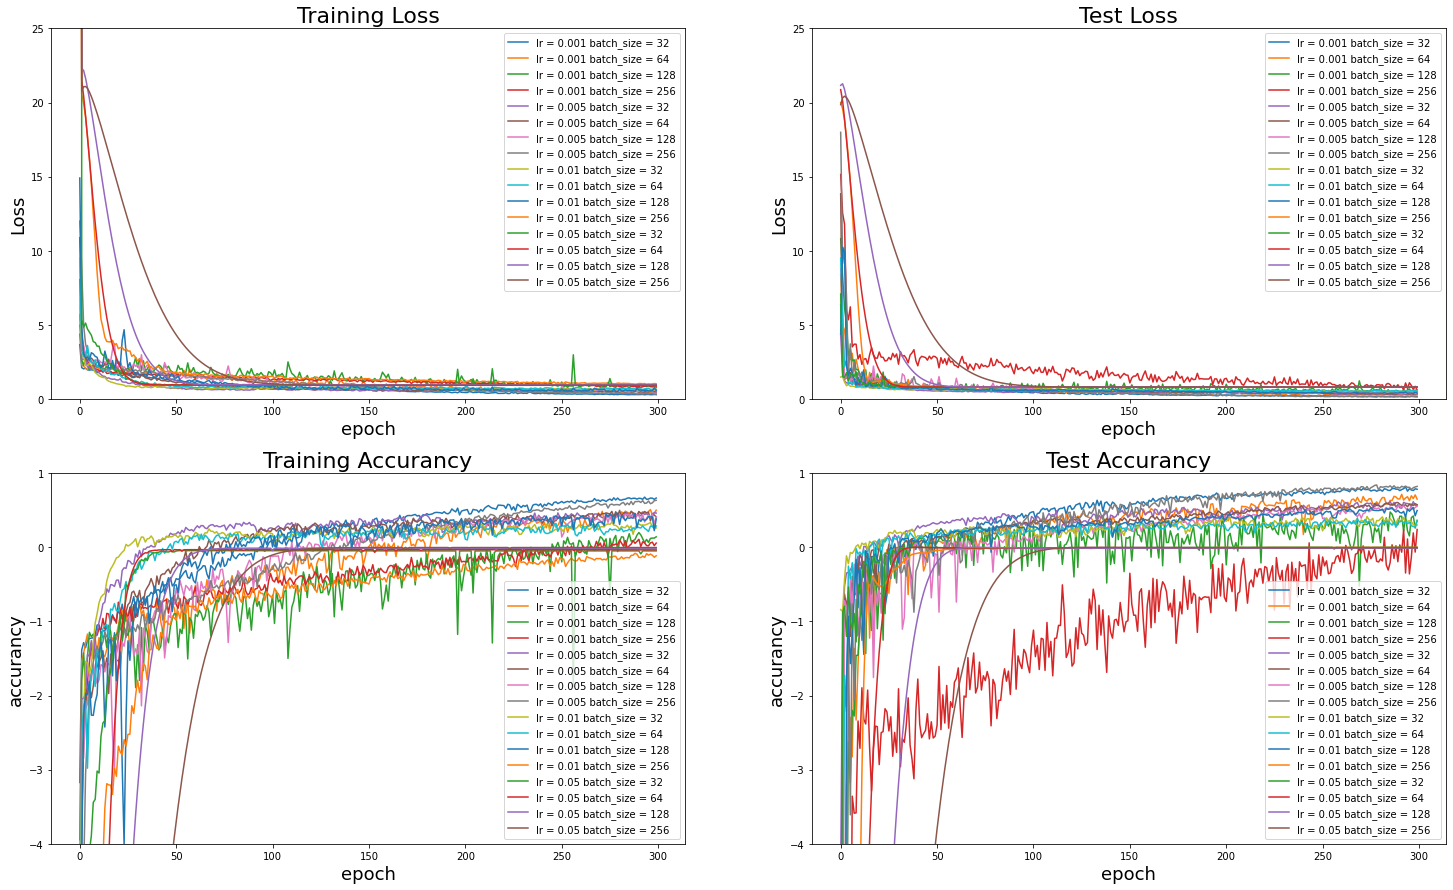

<Figure size 1800x1080 with 0 Axes>

In [17]:
def plot_all(ax, data_list):
    ax.plot(data_list[0],label="lr = 0.001 batch_size = 32")
    ax.plot(data_list[1],label="lr = 0.001 batch_size = 64")
    ax.plot(data_list[2],label="lr = 0.001 batch_size = 128")
    ax.plot(data_list[3],label="lr = 0.001 batch_size = 256")

    ax.plot(data_list[4],label="lr = 0.005 batch_size = 32")
    ax.plot(data_list[5],label="lr = 0.005 batch_size = 64")
    ax.plot(data_list[6],label="lr = 0.005 batch_size = 128")
    ax.plot(data_list[7],label="lr = 0.005 batch_size = 256")

    ax.plot(data_list[8],label="lr = 0.01 batch_size = 32")
    ax.plot(data_list[9],label="lr = 0.01 batch_size = 64")
    ax.plot(data_list[10],label="lr = 0.01 batch_size = 128")
    ax.plot(data_list[11],label="lr = 0.01 batch_size = 256")

    ax.plot(data_list[12],label="lr = 0.05 batch_size = 32")
    ax.plot(data_list[13],label="lr = 0.05 batch_size = 64")
    ax.plot(data_list[14],label="lr = 0.05 batch_size = 128")
    ax.plot(data_list[15],label="lr = 0.05 batch_size = 256")

figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(25,15))
plt.figure(figsize=(25,15))
ax1.set_title("Training Loss", fontsize=22)
plot_all(ax1, train_losses_all)
ax1.set_xlabel("epoch", fontsize=18)
ax1.set_ylabel("Loss", fontsize=18)
ax1.legend()
ax1.set_ylim([0, 25])

ax2.set_title("Test Loss", fontsize=22)
plot_all(ax2, test_losses_all)
ax2.set_xlabel("epoch", fontsize=18)
ax2.set_ylabel("Loss", fontsize=18)
ax2.legend()
ax2.set_ylim([0, 25])

ax3.set_title("Training Accurancy", fontsize=22)
plot_all(ax3, train_accs_all)
ax3.set_xlabel("epoch", fontsize=18)
ax3.set_ylabel("accurancy", fontsize=18)
ax3.legend()
ax3.set_ylim([-4,1])

ax4.set_title("Test Accurancy", fontsize=22)
plot_all(ax4, test_accs_all)
ax4.set_xlabel("epoch", fontsize=18)
ax4.set_ylabel("accurancy", fontsize=18)
ax4.legend()
ax4.set_ylim([-4,1])

plt.show()

In [15]:
for data in train_accs_all:
    print(data[-1])
    
print("___________________\n")

for data in test_accs_all:
    print(data[-1])
    
print("___________________\n")

for data in train_losses_all:
    print(data[-1])

print("___________________\n")

for data in test_losses_all:
    print(data[-1])   
    

0.664719551351624
0.5008185034988548
0.14143563610958862
0.056812546398757637
0.46147381397593706
0.4082271207925447
0.41287899297120156
0.6331154229173585
0.26012598723196634
0.2886973621562012
0.38283661891352283
-0.11416744981781708
-0.049054594894158435
-0.03477098721876451
-0.011871264208380786
-0.003364209281825755
___________________

0.7827961574567179
0.6495598164951708
0.36147490736809174
0.2404593873310562
0.563572052482459
0.574311578413198
0.5547144772977315
0.8212978388709216
0.30163231947651603
0.36230125000145286
0.4963469359360603
-3.423369403510179e-07
-0.00113255696848924
-0.009436471053657636
-0.011404692266979932
-0.004964885023183374
___________________

0.29522093964947593
0.4523393615432408
0.798867978155613
0.867765337228775
0.47691133485900034
0.5357422763886659
0.5519874369104704
0.3411255180835724
0.6604513578944736
0.6494658978089042
0.5730005869021019
1.0255364278952281
0.9460197965304057
0.9498504918554554
0.9578429063161215
0.9250758091608683
___________

### 2 best models

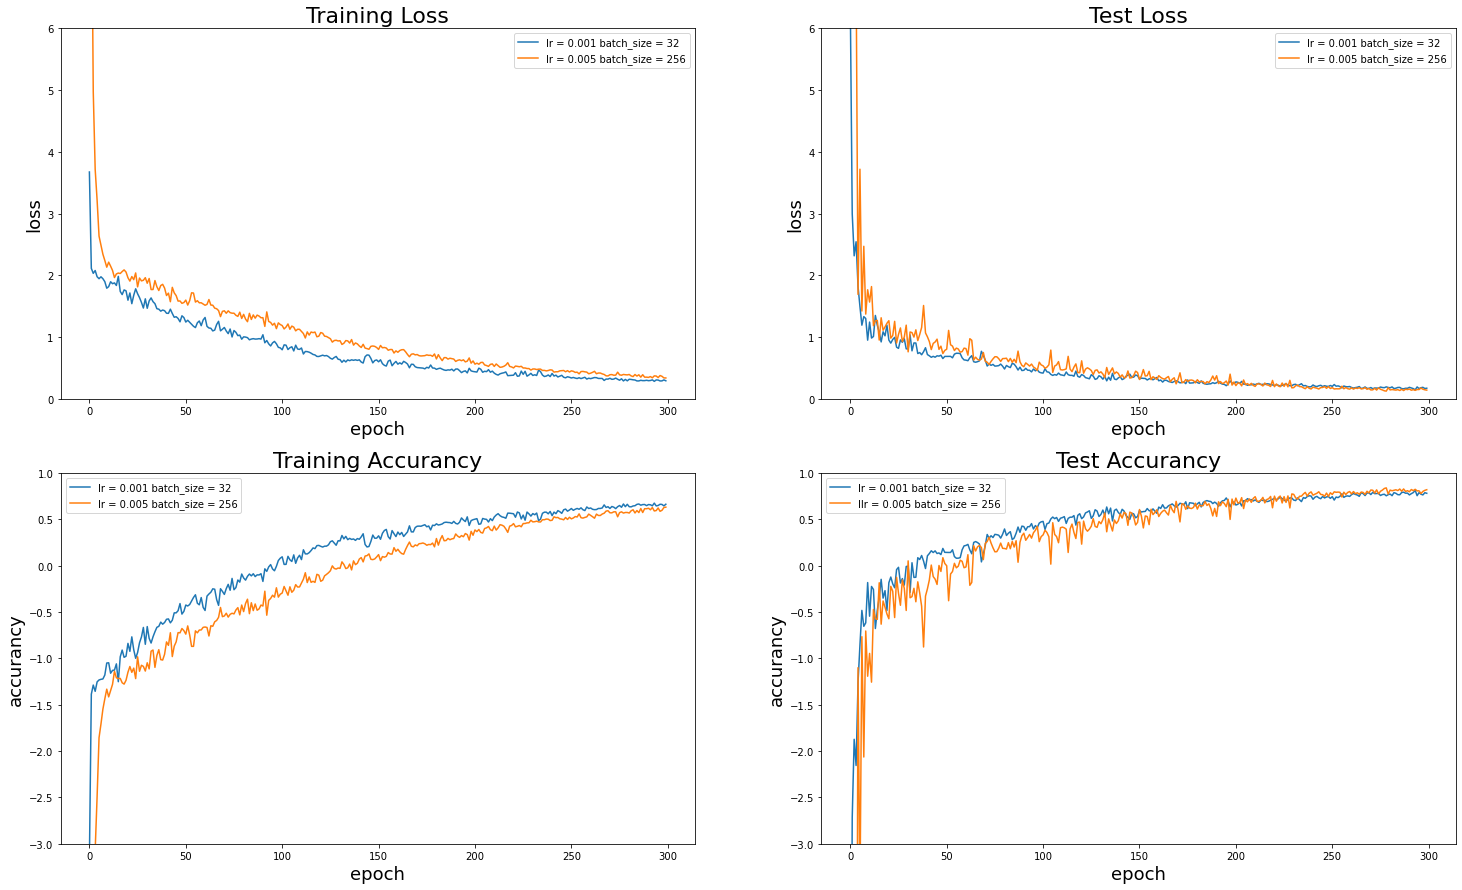

<Figure size 432x288 with 0 Axes>

In [24]:
figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(25,15))
plt.figure()
ax1.set_title("Training Loss", fontsize=22)
ax1.plot(train_losses_all[0],label="lr = 0.001 batch_size = 32")
ax1.plot(train_losses_all[7],label="lr = 0.005 batch_size = 256")
ax1.set_xlabel("epoch", fontsize=18)
ax1.set_ylabel("loss", fontsize=18)
ax1.legend()
ax1.set_ylim([0, 6])

ax2.set_title("Test Loss", fontsize=22)
ax2.plot(test_losses_all[0],label="lr = 0.001 batch_size = 32")
ax2.plot(test_losses_all[7],label="lr = 0.005 batch_size = 256")
ax2.set_xlabel("epoch", fontsize=18)
ax2.set_ylabel("loss", fontsize=18)
ax2.legend()
ax2.set_ylim([0, 6])

ax3.set_title("Training Accurancy", fontsize=22)
ax3.plot(train_accs_all[0],label="lr = 0.001 batch_size = 32")
ax3.plot(train_accs_all[7],label="lr = 0.005 batch_size = 256")
ax3.set_xlabel("epoch", fontsize=18)
ax3.set_ylabel("accurancy", fontsize=18)
ax3.legend()
ax3.set_ylim([-3,1])

ax4.set_title("Test Accurancy", fontsize=22)
ax4.plot(test_accs_all[0],label="lr = 0.001 batch_size = 32")
ax4.plot(test_accs_all[7],label="llr = 0.005 batch_size = 256")
ax4.set_xlabel("epoch", fontsize=18)
ax4.set_ylabel("accurancy", fontsize=18)
ax4.legend()
ax4.set_ylim([-3,1])
plt.show()

## 4.2. Training

In [48]:
train_dataset = TensorDataset(torch.FloatTensor(X_train_all.values), torch.FloatTensor(y_train_all.values.reshape(-1, 1)))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

test_dataset = TensorDataset(torch.FloatTensor(X_test.values), torch.FloatTensor(y_test.values.reshape(-1, 1)))
test_loader = DataLoader(test_dataset, batch_size=353, shuffle=False)

In [49]:
model = FCNN()
model.cuda()

epochs = 300
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), 0.001)

train_losses = []
test_losses = []
train_accs = []
test_accs = []

best_value = 1
best_params = {'epoch': None, 'train_loss': None, 'test_loss': None,'train_acc': None,'test_acc': None}
writer = SummaryWriter()

for epoch in range(1, epochs + 1):
    
    print('################## EPOCH {} ##################'.format(epoch))
    
    model.train()
    train_correct = 0
    train_loss = 0

    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_correct += metrics.r2_score(target.cpu().detach().numpy(), output.cpu().detach().numpy())
            
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_acc = train_correct/len(train_loader)
    train_accs.append(train_acc)
    writer.add_scalar("Loss/train", train_loss, epoch)
    writer.add_scalar("R2/train", train_acc, epoch)
    print('Train Avg. loss: {}, Accuracy: {}'.format(train_loss, train_acc))
    
    model.eval()
    
    test_loss = 0
    test_correct = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.cuda(), target.cuda()
            output = model(data)
            test_loss += criterion(output, target).item()
            test_correct += metrics.r2_score(target.cpu().detach().numpy(), output.cpu().detach().numpy())
        
    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    test_acc =test_correct/len(test_loader)
    test_accs.append(test_acc)

    if test_loss<best_value:
        best_value = test_loss
        torch.save(model.state_dict(), '../../models/solub_maccs_fcnn_model.pt')
        best_params['epoch'] = epoch
        best_params['train_loss'] = train_loss
        best_params['test_loss'] = test_loss
        best_params['train_acc'] = train_acc
        best_params['test_acc'] = test_acc 
    writer.add_scalar("Loss/test", test_loss, epoch)
    writer.add_scalar("R2/test", test_acc, epoch)

    print('Test Avg. loss: {}, Accuracy: {}'.format(test_loss, test_acc))

writer.flush()
writer.close()

print(best_params)

################## EPOCH 1 ##################
Train Avg. loss: 3.9874510871039495, Accuracy: -3.471832047777301
Test Avg. loss: 6.013904094696045, Accuracy: -5.569655761893093
################## EPOCH 2 ##################
Train Avg. loss: 2.1417238063282436, Accuracy: -1.4540041733245939
Test Avg. loss: 2.974477529525757, Accuracy: -2.2493523576108543
################## EPOCH 3 ##################
Train Avg. loss: 2.2034292936325075, Accuracy: -1.4398275080984104
Test Avg. loss: 3.7062981128692627, Accuracy: -3.0488015173622722
################## EPOCH 4 ##################
Train Avg. loss: 2.171448993682861, Accuracy: -1.429771671777765
Test Avg. loss: 2.257215738296509, Accuracy: -1.4658075026909598
################## EPOCH 5 ##################
Train Avg. loss: 2.1951636764738294, Accuracy: -1.4942290894597738
Test Avg. loss: 1.1458392143249512, Accuracy: -0.2517274348928049
################## EPOCH 6 ##################
Train Avg. loss: 1.9598063892788358, Accuracy: -1.224639556141624


Train Avg. loss: 1.400244528717465, Accuracy: -0.6081341678317616
Test Avg. loss: 0.8624498248100281, Accuracy: 0.05785026748920652
################## EPOCH 48 ##################
Train Avg. loss: 1.2548205269707573, Accuracy: -0.4329076747744395
Test Avg. loss: 0.9922696352005005, Accuracy: -0.08396634110543477
################## EPOCH 49 ##################
Train Avg. loss: 1.2705993003315397, Accuracy: -0.43818753645151476
Test Avg. loss: 0.8062655925750732, Accuracy: 0.11922655040106822
################## EPOCH 50 ##################
Train Avg. loss: 1.3387263271543715, Accuracy: -0.5080573158438987
Test Avg. loss: 0.848121702671051, Accuracy: 0.07350242188681688
################## EPOCH 51 ##################
Train Avg. loss: 1.2286040706766976, Accuracy: -0.37915541987694523
Test Avg. loss: 0.863756537437439, Accuracy: 0.05642269571625236
################## EPOCH 52 ##################
Train Avg. loss: 1.2132150769233703, Accuracy: -0.36714156105116735
Test Avg. loss: 0.90518367290496

Train Avg. loss: 0.8552380441791482, Accuracy: 0.03353407315395845
Test Avg. loss: 0.7949079275131226, Accuracy: 0.1316337803083647
################## EPOCH 94 ##################
Train Avg. loss: 0.9280346353848775, Accuracy: -0.04884363036361257
Test Avg. loss: 0.7759221196174622, Accuracy: 0.15237407907285383
################## EPOCH 95 ##################
Train Avg. loss: 0.8024651121762064, Accuracy: 0.08744140321117236
Test Avg. loss: 0.7939248085021973, Accuracy: 0.13270772619367988
################## EPOCH 96 ##################
Train Avg. loss: 0.8659413015676869, Accuracy: 0.027233639663019442
Test Avg. loss: 0.7564054727554321, Accuracy: 0.1736942644211953
################## EPOCH 97 ##################
Train Avg. loss: 0.8010619242986043, Accuracy: 0.08994763228777962
Test Avg. loss: 0.7943239808082581, Accuracy: 0.132271643149375
################## EPOCH 98 ##################
Train Avg. loss: 0.7918034904532962, Accuracy: 0.09858157418069169
Test Avg. loss: 0.7798442840576172,

Train Avg. loss: 0.6597533868418799, Accuracy: 0.25923659622665773
Test Avg. loss: 0.7350170016288757, Accuracy: 0.19705927515701116
################## EPOCH 140 ##################
Train Avg. loss: 0.6070703400505914, Accuracy: 0.33222352447352355
Test Avg. loss: 0.7230148315429688, Accuracy: 0.21017051154841926
################## EPOCH 141 ##################
Train Avg. loss: 0.6117615527576871, Accuracy: 0.3151386572562636
Test Avg. loss: 0.72591632604599, Accuracy: 0.20700085021565195
################## EPOCH 142 ##################
Train Avg. loss: 0.6022538198365106, Accuracy: 0.3303302778562367
Test Avg. loss: 0.7106930613517761, Accuracy: 0.2236309656347838
################## EPOCH 143 ##################
Train Avg. loss: 0.549569962422053, Accuracy: 0.3817916142029953
Test Avg. loss: 0.7165207266807556, Accuracy: 0.21726478474241961
################## EPOCH 144 ##################
Train Avg. loss: 0.5674957974089516, Accuracy: 0.3618681311892366
Test Avg. loss: 0.7428992390632629, 

Train Avg. loss: 0.47978065643045636, Accuracy: 0.4580692806727231
Test Avg. loss: 0.7194682955741882, Accuracy: 0.2140448443896109
################## EPOCH 186 ##################
Train Avg. loss: 0.45987775590684676, Accuracy: 0.4808479026105235
Test Avg. loss: 0.6843927502632141, Accuracy: 0.2523617390187981
################## EPOCH 187 ##################
Train Avg. loss: 0.4338452246454027, Accuracy: 0.5088521421521235
Test Avg. loss: 0.6977382302284241, Accuracy: 0.23778301101146793
################## EPOCH 188 ##################
Train Avg. loss: 0.4302356696791119, Accuracy: 0.5103954734948757
Test Avg. loss: 0.6840284466743469, Accuracy: 0.25275967265128796
################## EPOCH 189 ##################
Train Avg. loss: 0.4662016304002868, Accuracy: 0.47505778115059105
Test Avg. loss: 0.6802203059196472, Accuracy: 0.256919787644467
################## EPOCH 190 ##################
Train Avg. loss: 0.4422065774599711, Accuracy: 0.5073143161053152
Test Avg. loss: 0.6954351663589478,

Train Avg. loss: 0.3651057677136527, Accuracy: 0.588667323255381
Test Avg. loss: 0.6749699711799622, Accuracy: 0.2626552971824099
################## EPOCH 232 ##################
Train Avg. loss: 0.3798120306597816, Accuracy: 0.5718682739161357
Test Avg. loss: 0.6871403455734253, Accuracy: 0.24936031010280646
################## EPOCH 233 ##################
Train Avg. loss: 0.3928929405079948, Accuracy: 0.556636974708161
Test Avg. loss: 0.6710386276245117, Accuracy: 0.26694991584881633
################## EPOCH 234 ##################
Train Avg. loss: 0.3924572043948703, Accuracy: 0.5548701803183972
Test Avg. loss: 0.6797161102294922, Accuracy: 0.25747055321279755
################## EPOCH 235 ##################
Train Avg. loss: 0.4181670109430949, Accuracy: 0.5419805736763423
Test Avg. loss: 0.6780878305435181, Accuracy: 0.25924932987612115
################## EPOCH 236 ##################
Train Avg. loss: 0.3747191127803591, Accuracy: 0.5851827566822775
Test Avg. loss: 0.6725715398788452, A

Train Avg. loss: 0.3324379411008623, Accuracy: 0.6239074444928717
Test Avg. loss: 0.6962330937385559, Accuracy: 0.23942728510156874
################## EPOCH 278 ##################
Train Avg. loss: 0.35216228200329674, Accuracy: 0.60190323539769
Test Avg. loss: 0.6873049736022949, Accuracy: 0.24918045878277828
################## EPOCH 279 ##################
Train Avg. loss: 0.33155733010886856, Accuracy: 0.6254423841379487
Test Avg. loss: 0.7015989422798157, Accuracy: 0.23356554952481157
################## EPOCH 280 ##################
Train Avg. loss: 0.3173020193974177, Accuracy: 0.6402378263546861
Test Avg. loss: 0.7035343647003174, Accuracy: 0.2314512637628866
################## EPOCH 281 ##################
Train Avg. loss: 0.32042421268092264, Accuracy: 0.6383421324328228
Test Avg. loss: 0.6844910979270935, Accuracy: 0.2522543036712499
################## EPOCH 282 ##################
Train Avg. loss: 0.32403926278154055, Accuracy: 0.6305357899614823
Test Avg. loss: 0.6977286338806152

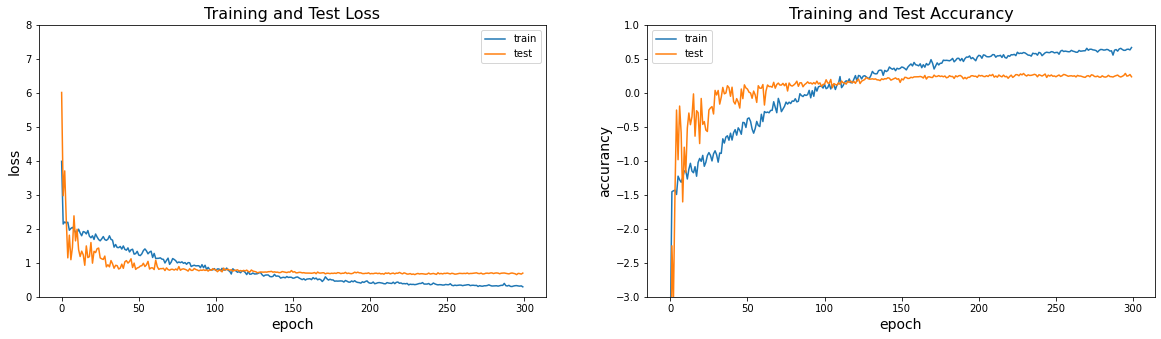

<Figure size 1440x360 with 0 Axes>

In [50]:
figure, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,5))
plt.figure(figsize=(20,5))
ax1.set_title("Training and Test Loss", fontsize=16)
ax1.plot(train_losses,label="train")
ax1.plot(test_losses,label="test")
ax1.set_xlabel("epoch", fontsize=14)
ax1.set_ylabel("loss", fontsize=14)
ax1.set_ylim([0,8])
ax1.legend()

ax2.set_title("Training and Test Accurancy", fontsize=16)
ax2.plot(train_accs,label="train")
ax2.plot(test_accs,label="test")
ax2.set_xlabel("epoch", fontsize=14)
ax2.set_ylabel("accurancy", fontsize=14)
ax2.set_ylim([-3,1])
ax2.legend()
plt.show()

In [51]:
model = FCNN()
model.load_state_dict(torch.load('../../models/solub_maccs_fcnn_model.pt'))
model.cuda()
model.eval()

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.cuda(), target.cuda()
        output = model(data)
        predictons = output.cpu().detach().numpy()
        print_evaluate(target.cpu().detach().numpy(), predictons)

MAE: 0.6514484
MSE: 0.6522637
RMSE: 0.80762845
R2 Square 0.2874599246989574 

